<h2 style="text-align:center; background-color:#d1f2d6; color:black;padding:12px;"><b> Quebec Residential Property Price Prediction - Machine Learning Models</b></h2>

---

<p style="text-align:right"><b> Project Creator: Flora Wong (Yuen Ling) </b></p>

**Notebook Introduction**

This project aims at analyzing the latest data regarding real-estates in Québec and building machine learnning models that can predict property prices in Québec.

In this project, I have scraped the lastest data from: <br>
> - [ Centris.ca - Québec’s real estate ](https://www.centris.ca/en/properties~for-sale)

**Questions to Explored** 
1. The Distribution of Prices of Properties in Quebec
2. The Proportion of Types of Properties in Quebec
3. The Important Features
5. The best model in predicting property price

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Notebook Table of Content</b></h2>


1. **Part I - Necessary Libraries**

2. **Part II - Web Scraping**

3. **Part III - Data Cleanning + Preprocessing**

4. **Part IV - EDA + Visualization**

6. **Part V - Statistical Analysis**
    - StatsModel
<br> </br>
7. **Part VI - Machine Learnning Models**
    - LassoCV Model
    - RidgeCV Model
    - ElasticNetCV Model
<br> </br>
8. **Part VII - The Best Model + Summary**


<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part I - Necessary Libraries </b></h2>

In [12]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part II - Web Scraping </b></h2>

## Web Scrapping

In [2]:
# Create an empty DataFrame to store all property data
total_property_dataset = pd.DataFrame()

for run in range(2): # run 2 times, each times scrape 1000 pages max.
    
    try: 
        from selenium import webdriver
        from selenium.webdriver.common.by import By
        from selenium.webdriver.support.ui import WebDriverWait
        from selenium.webdriver.support import expected_conditions as EC
        from selenium.webdriver.common.action_chains import ActionChains
        import pandas as pd
        import time
        
        # Set up the web driver
        driver = webdriver.Chrome()
        
        # Create an empty list to store data from each page
        property_data = []
        
        try:
            # 1) Navigate to the main listings page
            driver.get('https://www.centris.ca/en/properties~for-sale')
        
            # 2) Handle the popup windows if it appears
            try:
                first_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[@id="didomi-notice-learn-more-button"]/span')))
                first_button.click()
        
                second_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[@id="didomi-radio-option-disagree-to-all"]/span')))
                second_button.click()
        
                third_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[@id="didomi-consent-popup"]/div/div/div/div/div[4]/div/button')))
                third_button.click()
            except:
                print("Consent popup not found.")
        
            # 3) Click the "View Summary" button
            try:
                view_summary_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//*[@id="ButtonViewSummary"]')))
                view_summary_button.click()
            except:
                print("View Summary button not found or could not be clicked.")
        
            # 4) Loop through 1000 pages and extract property data
            for page in range(1000):

                data = {} # Create an empty dictionary to store data for each page
        
                # Try scraping detailed data + Allow time to load the page to scrape 
                try: #1
                    buy_price = WebDriverWait(driver, 5).until(
                        EC.presence_of_element_located((By.ID, "BuyPrice")))
                    data["Buy Price"] = buy_price.text
                except:
                    data["Buy Price"] = None  # Set to "None" if missing

                try: #2
                    page_title = WebDriverWait(driver, 2).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "span[data-id='PageTitle']")))
                    data["Property Type"] = page_title.text
                except:
                    data["Property Type"] = None
        
                try: #3
                    address = WebDriverWait(driver, 2).until(
                         EC.presence_of_element_located((By.CSS_SELECTOR, "h2[itemprop='address']")))
                    data["Address"] = address.text
                except:
                    data["Address"] = None
        
                try: #4
                    rooms = WebDriverWait(driver, 2).until(
                         EC.presence_of_element_located((By.CSS_SELECTOR, 'div[class="col-lg-3 col-sm-6 piece"]')))
                    data["Rooms"] = rooms.text
                except:
                    data["Rooms"] = None
        
                try: #5
                    bedrooms = WebDriverWait(driver, 2).until(
                         EC.presence_of_element_located((By.CSS_SELECTOR, 'div[class="col-lg-3 col-sm-6 cac"]')))
                    data["Bedrooms"] = bedrooms.text
                except:
                    data["Bedrooms"] = None
        
                try: #6
                    bathrooms = WebDriverWait(driver, 2).until(
                         EC.presence_of_element_located((By.CSS_SELECTOR, 'div[class="col-lg-3 col-sm-6 sdb"]')))
                    data["Bathrooms"] = bathrooms.text
                except:
                    data["Bathrooms"] = None
        
                #7 - Extract Flexbox Data - Under the Class 'carac-container' - Find all the elements 'title' + 'value' under this class
                try: 
                    containers = WebDriverWait(driver, 2).until(
                         EC.presence_of_all_elements_located((By.CLASS_NAME, 'carac-container')))
                
                    for container in containers:
                        try:
                            title_element = container.find_element(By.CSS_SELECTOR, 'div[class="carac-title"]')
                            value_element = container.find_element(By.CSS_SELECTOR, 'div[class="carac-value"]')
                            data[title_element.text.strip()] = value_element.text.strip()
                        except:
                            pass  # Ignore if any element is missing within the container
                except:
                    pass # Ignore if there is no flexbox data found
                    
                # Add each page's data (that was stored in the dictionary) into the "property_data" list
                property_data.append(data)
        
                # After extracting data on that page, then navigate to the next page
                try:
                    time.sleep(1)
                    next_button = driver.find_element(By.CSS_SELECTOR, "#divWrapperPager > ul > li.next > a")
                    ActionChains(driver).move_to_element(next_button).click().perform()  #
                    #ActionChains are a way to automate low level interactions such as mouse movements, mouse button actions.
                    #Perform a complex chain of actions : 1) Moving the mouse to the middle of an element, 2) Click.
                
                except:
                    print("Next button not found or end of pages reached.")
                    break # if it cannot navigate to the next page, exits the loop entirely
        
        except:
            print(f"An error occurred.")
        
        finally:
            driver.quit() # Quit the driver
            
        # Add each run's data into "total_property" list  
        total_property.append(property_data)
        
    except:
        pass


    # Create a DataFrame from the current run's property data and append it to the total dataset
    run_dataframe = pd.DataFrame(property_data)
    total_property_dataset = pd.concat([total_property_dataset, run_dataframe], ignore_index=True)

print(total_property_dataset.head())

total_property_dataset.to_csv('total_property_dataset.csv', index=False)

Next button not found or end of pages reached.
Next button not found or end of pages reached.
  Buy Price    Property Type  \
0  $199,000   House for sale   
1  $199,000   House for sale   
2  $399,000  Duplex for sale   
3  $459,000   Condo for sale   
4  $699,900     Lot for sale   

                                             Address    Rooms    Bedrooms  \
0                          7311, 2e Avenue, Chertsey  4 rooms   1 bedroom   
1                          7311, 2e Avenue, Chertsey  4 rooms   1 bedroom   
2       48 - 50, Rue Saint-Alexis, Saint-Chrysostome  8 rooms  2 bedrooms   
3  3998, Rue Antoine-Bedwani, Laval (Chomedey), N...  8 rooms  2 bedrooms   
4         184, Rang Point-du-Jour Nord, L'Assomption     None        None   

    Bathrooms      Building style Year built    Lot area Parking (total)  ...  \
0  1 bathroom  Bungalow, Detached       1942  6,282 sqft    Driveway (2)  ...   
1  1 bathroom                 NaN        NaN         NaN             NaN  ...   
2  1 ba

Remarks : Repeatedly running the above cell for several times to scrap more data; meanwhile, saving those datasets with desirable names.

## Load Datasets containing Scraped data

In [3]:
df1 = pd.read_csv("../Data/total_property_dataset_1.csv")
df2 = pd.read_csv("../Data/total_property_dataset_2.csv")
df3 = pd.read_csv("../Data/total_property_dataset_3.csv")
df4 = pd.read_csv("../Data/total_property_dataset_4.csv")
df5 = pd.read_csv("../Data/total_property_dataset_5.csv")
df6 = pd.read_csv("../Data/total_property_dataset_6.csv")
df7 = pd.read_csv("../Data/total_property_dataset_7.csv")
df8 = pd.read_csv("../Data/total_property_dataset_8.csv")

## Explore Scraped Data

In [6]:
df1.sample(1)

Buy Price   Property Type                                 Address  \
1845  $299,000  House for sale  13, Rue Gagné, Repentigny (Repentigny)   

        Rooms                    Bedrooms   Bathrooms Use of property  \
1845  6 rooms  3 bedrooms (2 in basement)  1 bathroom             NaN   

               Building style Year built Building area (at ground level)  ...  \
1845  Bungalow, Semi-detached       1960                             NaN  ...   

     Living area Zoning Intergenerational Pool Accessibility Gross area  \
1845         NaN    NaN               NaN  NaN           NaN        NaN   

     Parking (excluded from the price) Available commercial area  \
1845                               NaN                       NaN   

     Residential unit Option of leased parking  
1845              NaN                      NaN  

[1 rows x 31 columns]

In [8]:
df2.sample(1)

Buy Price   Property Type  \
157  $1,250,000  House for sale   

                                               Address     Rooms    Bedrooms  \
157  2810, Rue Girouard Ouest, Saint-Hyacinthe, Nei...  18 rooms  4 bedrooms   

                        Bathrooms                Building style  \
157  1 bathroom and 1 powder room  Two or more storey, Detached   

         Year built Living area     Lot area  ... Use of property  \
157  1872, Historic         NaN  12,948 sqft  ...             NaN   

    Number of units Residential units Main unit Potential gross revenue  \
157             NaN               NaN       NaN                     NaN   

    Zoning Building area (at ground level) Intergenerational  \
157    NaN                             NaN               NaN   

    Parking (excluded from the price) Available commercial area  
157                               NaN                       NaN  

[1 rows x 29 columns]

In [10]:
df3.sample(1)

Buy Price   Property Type                           Address     Rooms  \
955  $269,000  House for sale  6, Chemin des Geais-Bleus, Ripon  10 rooms   

       Bedrooms                     Bathrooms Lot area Zoning  \
955  3 bedrooms  1 bathroom and 1 powder room      NaN    NaN   

    Additional features Move-in date  ... Number of units Residential units  \
955                 NaN          NaN  ...             NaN               NaN   

    Main unit Potential gross revenue Available commercial area  \
955       NaN                     NaN                       NaN   

    Residential unit Intergenerational Accessibility  \
955              NaN               NaN           NaN   

    Parking (excluded from the price) Type of operation  
955                               NaN               NaN  

[1 rows x 31 columns]

## Concatenate Datasets

In [12]:
df_all = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)

df_all.to_csv('total_property_dataset_all.csv', index=False) # Save to csv.file

In [14]:
df_all.shape

(11016, 32)

In [16]:
df_all.sample(5)

Buy Price         Property Type  \
560   $399,000        Condo for sale   
7743  $859,900        House for sale   
2757  $800,000        House for sale   
1086  $160,000  Mobile home for sale   
3121  $434,838        Condo for sale   

                                                Address     Rooms  \
560   9130, Rue de Morelia, Québec (Les Rivières), N...  12 rooms   
7743                     5, Rue Rossini, Saint-Constant   9 rooms   
2757                     914Z, Route 321, Papineauville  10 rooms   
1086  17, Rue Yvon, Rouyn-Noranda, Neighbourhood Gra...   5 rooms   
3121  540, Rue Saint-Jean, apt. 107, Québec (La Cité...   7 rooms   

                        Bedrooms                     Bathrooms  \
560   3 bedrooms (2 in basement)                   2 bathrooms   
7743  5 bedrooms (2 in basement)  1 bathroom and 1 powder room   
2757  4 bedrooms (2 in basement)                   2 bathrooms   
1086                  2 bedrooms                    1 bathroom   
3121                  2 bedrooms                    1 bathroom   

     Use of property                Building style             Year built  \
560              NaN                           NaN                    NaN   
7743             NaN  Two or more storey, Detached                   2014   
2757             NaN            Bungalow, Detached                   1985   
1086             NaN                      Detached                   1974   
3121             NaN                           NaN  1964, Being converted   

     Building area (at ground level)  ... Zoning Intergenerational Pool  \
560                              NaN  ...    NaN               NaN  NaN   
7743                             NaN  ...    NaN               NaN  NaN   
2757                             NaN  ...    NaN               NaN  NaN   
1086                             NaN  ...    NaN               NaN  NaN   
3121                             NaN  ...    NaN               NaN  NaN   

     Accessibility Gross area Parking (excluded from the price)  \
560            NaN        NaN                               NaN   
7743           NaN        NaN                               NaN   
2757           NaN        NaN                               NaN   
1086           NaN        NaN                               NaN   
3121           NaN        NaN                               NaN   

     Available commercial area Residential unit Option of leased parking  \
560                        NaN              NaN                      NaN   
7743                       NaN              NaN                      NaN   
2757                       NaN              NaN                      NaN   
1086                       NaN              NaN                      NaN   
3121                       NaN              NaN                      NaN   

     Type of operation  
560                NaN  
7743               NaN  
2757               NaN  
1086               NaN  
3121               NaN  

[5 rows x 32 columns]

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part III - Data Cleanning + Preprocessing </b></h2>


## 1. Data Exploration

In [3]:
df_all = pd.read_csv('total_property_dataset_all.csv')

In [5]:
df_all.shape

(11016, 32)

In [7]:
df_all.sample(2)

Buy Price   Property Type  \
6506  $230,000  Condo for sale   
8593  $798,000  House for sale   

                                                Address     Rooms  \
6506  9100, Avenue Montesquieu, apt. 405, Montréal (...   3 rooms   
8593  2110, Chemin Saint-José, La Prairie, Neighbour...  10 rooms   

                        Bedrooms                      Bathrooms  \
6506                   1 bedroom                     1 bathroom   
8593  4 bedrooms (1 in basement)  2 bathrooms and 1 powder room   

     Use of property                Building style Year built  \
6506             NaN                           NaN        NaN   
8593             NaN  Two or more storey, Detached       2003   

     Building area (at ground level)  ... Zoning Intergenerational  \
6506                             NaN  ...    NaN               NaN   
8593                             NaN  ...    NaN               NaN   

              Pool Accessibility Gross area Parking (excluded from the price)  \
6506           NaN           NaN        NaN                               NaN   
8593  Above-ground           NaN        NaN                               NaN   

     Available commercial area Residential unit Option of leased parking  \
6506                       NaN              NaN                      NaN   
8593                       NaN              NaN                      NaN   

     Type of operation  
6506               NaN  
8593               NaN  

[2 rows x 32 columns]

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          10929 non-null  object
 1   Property Type                      10928 non-null  object
 2   Address                            10918 non-null  object
 3   Rooms                              9883 non-null   object
 4   Bedrooms                           9767 non-null   object
 5   Bathrooms                          9669 non-null   object
 6   Use of property                    432 non-null    object
 7   Building style                     6994 non-null   object
 8   Year built                         8597 non-null   object
 9   Building area (at ground level)    117 non-null    object
 10  Lot area                           6298 non-null   object
 11  Parking (total)                    6494 non-null   object
 12  Numb

## 2. Data Cleanning + Preprocessing 

### Check Duplicate Rows

In [13]:
duplicates = df_all.duplicated().sum() # Check the number of duplicates
duplicates

192

In [15]:
duplicate_rows = df_all[df_all.duplicated()] # Filter + display duplicate rows (the second occurance)
duplicate_rows.head()

Buy Price   Property Type  \
846   $1,369,900  House for sale   
942     $558,000  House for sale   
1304  $1,995,000  House for sale   
1404    $869,000  House for sale   
1942    $424,500  House for sale   

                                                Address     Rooms  \
846   22, Rue du Granier, Blainville, Neighbourhood ...  16 rooms   
942   7249Z, Chemin Royal, Saint-Laurent-de-l'Île-d'...  10 rooms   
1304  1233, Avenue James-LeMoine, Québec (Sainte-Foy...  16 rooms   
1404               13 - 13A, Rue des Cerisiers, Shannon  19 rooms   
1942                      165, Rue Martel, Saint-Lucien  11 rooms   

                        Bedrooms                      Bathrooms  \
846   4 bedrooms (1 in basement)  3 bathrooms and 1 powder room   
942                   4 bedrooms  2 bathrooms and 1 powder room   
1304                  3 bedrooms  3 bathrooms and 1 powder room   
1404  4 bedrooms (2 in basement)  2 bathrooms and 1 powder room   
1942                  3 bedrooms                    2 bathrooms   

     Use of property                Building style Year built  \
846              NaN  Two or more storey, Detached       2014   
942              NaN  Two or more storey, Detached       1889   
1304             NaN  Two or more storey, Detached       2018   
1404             NaN  Two or more storey, Detached       2009   
1942             NaN            Bungalow, Detached       2006   

     Building area (at ground level)  ... Zoning  \
846                              NaN  ...    NaN   
942                              NaN  ...    NaN   
1304                             NaN  ...    NaN   
1404                             NaN  ...    NaN   
1942                             NaN  ...    NaN   

                                      Intergenerational              Pool  \
846                                                 NaN  Heated, Inground   
942                                                 NaN               NaN   
1304                                                NaN               NaN   
1404  9 rooms, 2 bedrooms, 1 bathroom and 1 powder room               NaN   
1942                                                NaN               NaN   

     Accessibility Gross area Parking (excluded from the price)  \
846            NaN        NaN                               NaN   
942            NaN        NaN                               NaN   
1304           NaN        NaN                               NaN   
1404           NaN        NaN                               NaN   
1942           NaN        NaN                               NaN   

     Available commercial area Residential unit Option of leased parking  \
846                        NaN              NaN                      NaN   
942                        NaN              NaN                      NaN   
1304                       NaN              NaN                      NaN   
1404                       NaN              NaN                      NaN   
1942                       NaN              NaN                      NaN   

     Type of operation  
846                NaN  
942                NaN  
1304               NaN  
1404               NaN  
1942               NaN  

[5 rows x 32 columns]

### Drop Duplicate Rows

In [18]:
df_no_duplicate = df_all.drop_duplicates().reset_index(drop=True)

In [20]:
df_no_duplicate.shape

(10824, 32)

In [22]:
df_no_duplicate.duplicated().sum()

0

### Save as a New DF containing Non-Duplicate Rows

In [25]:
df_no_duplicate.to_csv('df_no_duplicate.csv', index=False) # Save to csv.file
df = df_no_duplicate

### Check Null Values

In [28]:
df = pd.read_csv('df_no_duplicate.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10824 entries, 0 to 10823
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          10742 non-null  object
 1   Property Type                      10741 non-null  object
 2   Address                            10731 non-null  object
 3   Rooms                              9696 non-null   object
 4   Bedrooms                           9580 non-null   object
 5   Bathrooms                          9482 non-null   object
 6   Use of property                    432 non-null    object
 7   Building style                     6864 non-null   object
 8   Year built                         8419 non-null   object
 9   Building area (at ground level)    117 non-null    object
 10  Lot area                           6181 non-null   object
 11  Parking (total)                    6364 non-null   object
 12  Numb

### Drop Rows Containing Null Values in Certain Columns

In [33]:
#drop rows containing nan values in certain column
df = df.dropna(subset=['Buy Price']).reset_index(drop=True)
df = df.dropna(subset=['Property Type']).reset_index(drop=True)
df = df.dropna(subset=['Rooms']).reset_index(drop=True)
df = df.dropna(subset=['Bedrooms']).reset_index(drop=True)
df = df.dropna(subset=['Bathrooms']).reset_index(drop=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9241 entries, 0 to 9240
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          9241 non-null   object
 1   Property Type                      9241 non-null   object
 2   Address                            9180 non-null   object
 3   Rooms                              9241 non-null   object
 4   Bedrooms                           9241 non-null   object
 5   Bathrooms                          9241 non-null   object
 6   Use of property                    14 non-null     object
 7   Building style                     6207 non-null   object
 8   Year built                         7653 non-null   object
 9   Building area (at ground level)    4 non-null      object
 10  Lot area                           4763 non-null   object
 11  Parking (total)                    5754 non-null   object
 12  Number

### Narrow Down the Scope of Property Types

To drop Unwanted Property Types + Simplify Groups

In [39]:
# drop unwanted property types
drop_property_types = ['Lot for sale',
                       'Hobby farm for sale',
                       'Cottage for sale or for rent',
                       'Cottage for sale',
                       'Land for sale']

df = df[~df['Property Type'].isin(drop_property_types)]
df['Property Type'].unique()

array(['Quadruplex for sale', 'Condo for sale', 'House for sale',
       'Duplex for sale', 'Condominium house for sale',
       'Triplex for sale', 'Quintuplex for sale', 'Mobile home for sale',
       'Loft / Studio for sale', 'House for sale or for rent',
       'Condo for sale or for rent', 'Loft / Studio for sale or for rent',
       'Condominium house for sale or for rent'], dtype=object)

In [41]:
df.loc[:, 'Property Type'] = df['Property Type'].replace({
                                    "Condo for sale": "Condo",
                                    "Condo for sale or for rent": "Condo",
                                    "Condominium house for sale": "Condominium House",
                                    "Condominium house for sale or for rent": "Condominium House",
                                    "House for sale": "House",
                                    "House for sale or for rent": "House",
                                    "Duplex for sale":"Duplex",
                                    "Triplex for sale": "Triplex",
                                    "Quadruplex for sale": "Quadruplex",
                                    "Quintuplex for sale": "Quintuplex",
                                    "Loft / Studio for sale": "Loft / studio",
                                    "Loft / Studio for sale or for rent": "Loft / studio",
                                    "Mobile home for sale": "Mobile Home"})

In [43]:
df['Property Type'].unique()

array(['Quadruplex', 'Condo', 'House', 'Duplex', 'Condominium House',
       'Triplex', 'Quintuplex', 'Mobile Home', 'Loft / studio'],
      dtype=object)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   object
 1   Property Type                      7424 non-null   object
 2   Address                            7380 non-null   object
 3   Rooms                              7424 non-null   object
 4   Bedrooms                           7424 non-null   object
 5   Bathrooms                          7424 non-null   object
 6   Use of property                    14 non-null     object
 7   Building style                     4839 non-null   object
 8   Year built                         5932 non-null   object
 9   Building area (at ground level)    4 non-null      object
 10  Lot area                           3569 non-null   object
 11  Parking (total)                    4305 non-null   object
 12  Number of u

### Drop Unwanted / Irrelevant Columns

To drop specific columns which contains too many null values / redundant meannings / irrelevant meannings.

In [49]:
df.isnull().sum()

Buy Price                               0
Property Type                           0
Address                                44
Rooms                                   0
Bedrooms                                0
Bathrooms                               0
Use of property                      7410
Building style                       2585
Year built                           1492
Building area (at ground level)      7420
Lot area                             3855
Parking (total)                      3119
Number of units                      7410
Residential units                    7410
Main unit                            7410
Potential gross revenue              7410
Move-in date                         3597
Condominium type                     5244
Net area                             5919
Fireplace/Stove                      5682
Additional features                  4209
Living area                          6064
Zoning                               7399
Intergenerational                 

In [51]:
# Check the Patterns of the unique values in each columns, and the unique values's proportion to its column.
list = df.columns.to_list()
print(list)
for l in list:
    print(df[l].value_counts(normalize=True))

['Buy Price', 'Property Type', 'Address', 'Rooms', 'Bedrooms', 'Bathrooms', 'Use of property', 'Building style', 'Year built', 'Building area (at ground level)', 'Lot area', 'Parking (total)', 'Number of units', 'Residential units', 'Main unit', 'Potential gross revenue', 'Move-in date', 'Condominium type', 'Net area', 'Fireplace/Stove', 'Additional features', 'Living area', 'Zoning', 'Intergenerational', 'Pool', 'Accessibility', 'Gross area', 'Parking (excluded from the price)', 'Available commercial area', 'Residential unit', 'Option of leased parking', 'Type of operation']
Buy Price
$499,000      0.014278
$399,000      0.013739
$599,000      0.011988
$449,000      0.010506
$699,000      0.009564
                ...   
$739,500      0.000135
$359,988      0.000135
$1,775,000    0.000135
$184,900      0.000135
$1,578,000    0.000135
Name: proportion, Length: 1615, dtype: float64
Property Type
House                0.599542
Condo                0.266568
Duplex               0.041891
Tri

In [53]:
df = df.drop([
        'Use of property',                   # too many null values
        'Building style',                    # too many null values
        'Building area (at ground level)',   # too many null values
        'Number of units',                   # redundant + too many null values
        'Residential units',                 # too many null values
        'Main unit',                         # too many null values
        'Potential gross revenue',           # too many null values
        'Move-in date',                      # too many null values
        'Zoning',                            # too many null values
        'Intergenerational',                 # too many null values
        'Accessibility',                     # too many null values
        'Gross area',                        # too many null values
        'Available commercial area',         # too many null values + irrelavant 
        'Residential unit' ,                 # too many null values 
        'Type of operation',                 # too many null values + irrelavant 
        'Additional features',               # too many null values (uncertain of the actual meanning of null values- unknown/ non-display/ absence of certina features)
        'Fireplace/Stove'],                   # too many null values (uncertain of the actual meanning of null values- unknown/ non-display/ absence of certina features)
axis=1)         # too many null values + irrelavant 

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   object
 1   Property Type                      7424 non-null   object
 2   Address                            7380 non-null   object
 3   Rooms                              7424 non-null   object
 4   Bedrooms                           7424 non-null   object
 5   Bathrooms                          7424 non-null   object
 6   Year built                         5932 non-null   object
 7   Lot area                           3569 non-null   object
 8   Parking (total)                    4305 non-null   object
 9   Condominium type                   2180 non-null   object
 10  Net area                           1505 non-null   object
 11  Living area                        1360 non-null   object
 12  Pool       

### Fill Null Values with 0 for Specific Columns

In [58]:
# Areas-related columns
# Given the assumption of null values representing non-display or unknown, convert them w/ 0 for further convertion later.
df['Lot area']=df['Lot area'].fillna(0)                  # will further convert later
df['Net area']=df['Net area'].fillna(0)                  # will further convert later
df['Living area']=df['Living area'].fillna(0)            # will further convert later

# Other Special Features 
# Given the assumption of null values representing the absence of the specific features, convert them w/ 0.
df['Parking (total)']=df['Parking (total)'].fillna(0)
df['Pool']= df['Pool'].fillna(0)
df['Parking (excluded from the price)'] = df['Parking (excluded from the price)'].fillna(0)
df['Option of leased parking'] = df['Option of leased parking'].fillna(0)

### Convert Specific Columns into Numerical Columns

In [61]:
# Observe the patterns of specific columns 
numerical_columns =['Buy Price','Rooms','Bedrooms','Bathrooms','Living area','Net area','Lot area']
for col in numerical_columns:
    print(col)
    print(df[col].unique())

Buy Price
['$649,000' '$365,000' '$399,000' ... '$1,538,700' '$794,900' '$1,578,000']
Rooms
['9 rooms' '3 rooms' '8 rooms' '6 rooms' '21 rooms' '12 rooms' '13 rooms'
 '2 rooms' '11 rooms' '15 rooms' '10 rooms' '19 rooms' '7 rooms'
 '16 rooms' '14 rooms' '4 rooms' '20 rooms' '5 rooms' '18 rooms'
 '27 rooms' '23 rooms' '22 rooms' '1 room' '17 rooms' '24 rooms'
 '31 rooms' '26 rooms' '28 rooms' '25 rooms' '44 rooms' '30 rooms'
 '29 rooms' '38 rooms' '43 rooms' '32 rooms' '37 rooms']
Bedrooms
['2 bedrooms' '1 bedroom' '3 bedrooms' '5 bedrooms'
 '5 bedrooms (3 in basement)' '4 bedrooms' '2 bedrooms (1 in basement)'
 '5 bedrooms (2 in basement)' '6 bedrooms (2 in basement)'
 '3 bedrooms (1 in basement)' '4 bedrooms (2 in basement)'
 '5 bedrooms (1 in basement)' '4 bedrooms (1 in basement)'
 '1 bedroom in basement' '6 bedrooms' '3 bedrooms (2 in basement)'
 '6 bedrooms (3 in basement)' '5 bedrooms (4 in basement)'
 '4 bedrooms (3 in basement)' '7 bedrooms (2 in basement)'
 '2 bedrooms in base

In [63]:
# replace any string containing "$" and "," signs with " "space and convert to integer
df.loc[:, 'Buy Price'] = df['Buy Price'].replace(r'[\$,]', '', regex=True)
df['Buy Price'] = df['Buy Price'].astype(int)

In [65]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Rooms'] = df['Rooms'].astype(str)
df.loc[:, 'Rooms'] = df['Rooms'].str.extract(r'(\d+)')[0]
df['Rooms'] = df['Rooms'].astype(int)

In [67]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Bedrooms'] = df['Bedrooms'].astype(str)
df.loc[:, 'Bedrooms'] = df['Bedrooms'].str.extract(r'(\d+)')[0]
df['Bedrooms'] = df['Bedrooms'].astype(int)

In [69]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Bathrooms'] = df['Bathrooms'].astype(str)
df.loc[:, 'Bathrooms'] = df['Bathrooms'].str.extract(r'(\d+)')[0]
df['Bathrooms'] = df['Bathrooms'].astype(int)

In [71]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Living area'] = df['Living area'].astype(str)
df.loc[:, 'Living area'] = df['Living area'].replace(r',', '', regex=True)
df.loc[:, 'Living area'] = df['Living area'].str.extract(r'(\d+)')[0]
df['Living area'] = df['Living area'].astype(int)

In [73]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Net area'] = df['Net area'].astype(str)
df.loc[:, 'Net area'] = df['Net area'].replace(r',', '', regex=True)
df.loc[:, 'Net area'] = df['Net area'].str.extract(r'(\d+)')[0]
df['Net area'] = df['Net area'].astype(int)

In [75]:
# extracted string digits (1+ digits) into integers
df.loc[:, 'Lot area'] = df['Lot area'].astype(str)
df.loc[:, 'Lot area'] = df['Lot area'].replace(r',', '', regex=True)
df.loc[:, 'Lot area'] = df['Lot area'].str.extract(r'(\d+)')[0]
df['Lot area'] = df['Lot area'].astype(int)

In [77]:
df.sample(2)

Buy Price Property Type  \
1162     499000         House   
8139    1350000    Quintuplex   

                                                Address  Rooms  Bedrooms  \
1162  2151, Rue Poupart, Terrebonne (La Plaine), Nei...     10         4   
8139  5213 - 5219, Rue Jarry Est, Montréal (Saint-Lé...      9         3   

      Bathrooms Year built  Lot area           Parking (total)  \
1162          2       1986     10499              Driveway (4)   
8139          2       1991      5909  Driveway (3), Garage (1)   

     Condominium type  Net area  Living area Pool  \
1162              NaN         0            0    0   
8139              NaN         0         1260    0   

     Parking (excluded from the price) Option of leased parking  
1162                                 0                        0  
8139                                 0                        0

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7380 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Year built                         5932 non-null   object
 7   Lot area                           7424 non-null   int64 
 8   Parking (total)                    7424 non-null   object
 9   Condominium type                   2180 non-null   object
 10  Net area                           7424 non-null   int64 
 11  Living area                        7424 non-null   int64 
 12  Pool       

### Convert Areas-related columns

In [82]:
areas_related_columns = ['Living area','Net area','Lot area']
for col in areas_related_columns:
    print(df[col].value_counts(normalize=True))

Living area
0       0.816810
1200    0.001482
1500    0.001347
1360    0.001078
1248    0.001078
          ...   
1       0.000135
1501    0.000135
833     0.000135
1620    0.000135
2788    0.000135
Name: proportion, Length: 844, dtype: float64
Net area
0       0.797279
1100    0.001482
896     0.001078
919     0.001078
948     0.001078
          ...   
301     0.000135
1760    0.000135
854     0.000135
614     0.000135
1295    0.000135
Name: proportion, Length: 755, dtype: float64
Lot area
0          0.519262
5000       0.003772
6000       0.003502
7000       0.002020
5400       0.001751
             ...   
2483554    0.000135
17500      0.000135
5186       0.000135
439558     0.000135
1589166    0.000135
Name: proportion, Length: 2655, dtype: float64


### 'Living area' column

In [85]:
df_living_area = df.sort_values(by='Living area',ascending=False)
df_living_area.head(2)

Buy Price Property Type  \
351     869000         House   
178    6629850         House   

                                               Address  Rooms  Bedrooms  \
351               13 - 13A, Rue des Cerisiers, Shannon     19         4   
178  575, Chemin de Cassiopée, Mont-Tremblant, Neig...     15         5   

     Bathrooms Year built  Lot area Parking (total) Condominium type  \
351          2       2009     21533               0              NaN   
178          7       2024     24862      Garage (3)              NaN   

     Net area  Living area    Pool Parking (excluded from the price)  \
351         0        21531       0                                 0   
178         0        17470  Indoor                                 0   

    Option of leased parking  
351                        0  
178                        0

In [87]:
# Create label group
# Define the 8 bin edges
bins = [-1, 0, 500, 1000, 2000, 5000, 10000, 15000, 25000]
labels = ['unknown', '1-500sq', '501-1000sq', '1001-2000sq', '2001-5000sq', '5001-10000sq', '10001-15000sq', '>15000sq']

# Create a new column with binned categories
df['Living_area_groups'] = pd.cut(df['Living area'], bins=bins, labels=labels, right=True)
df['Living_area_groups'] = df['Living_area_groups'].astype(str)
df = df.drop('Living area',axis=1)
print(df['Living_area_groups'].head(2))

0    unknown
1    unknown
Name: Living_area_groups, dtype: object


In [89]:
df['Living_area_groups'].unique()

array(['unknown', '1001-2000sq', '2001-5000sq', '501-1000sq', '>15000sq',
       '5001-10000sq', '1-500sq', '10001-15000sq'], dtype=object)

### 'Net area' Column

In [92]:
df_net_area = df.sort_values(by='Net area',ascending=False)
df_net_area.head(2)

Buy Price Property Type  \
5110    7650000         Condo   
1698    6700000         Condo   

                                                Address  Rooms  Bedrooms  \
5110  1650, Rue Sherbrooke Ouest, apt. 18W, Montréal...     22         4   
1698  1050, Rue Drummond, apt. 4801, Montréal (Ville...      9         5   

      Bathrooms Year built  Lot area Parking (total) Condominium type  \
5110          3       2006         0      Garage (3)          Divided   
1698          4        NaN         0               0          Divided   

      Net area Pool Parking (excluded from the price)  \
5110      5816    0                                 0   
1698      4959    0                                 0   

     Option of leased parking Living_area_groups  
5110                        0            unknown  
1698                        0            unknown

In [94]:
# Define bins and labels for "Net area" column
bins = [-1, 0, 500, 1000, 2000, 3000, 6000]
labels = ['unknown', '1-500sq', '501-1000sq', '1001-2000sq', '2001-3000sq', '3001-6000sq']

# Create a new column with binned categories
df['Net_area_groups'] = pd.cut(df['Net area'], bins=bins, labels=labels, right=True)
df['Net_area_groups'] = df['Net_area_groups'].astype(str)
df = df.drop('Net area',axis=1)
df['Net_area_groups'].head(2)

0    1001-2000sq
1    1001-2000sq
Name: Net_area_groups, dtype: object

In [96]:
df['Net_area_groups'].unique()

array(['1001-2000sq', '501-1000sq', 'unknown', '1-500sq', '2001-3000sq',
       '3001-6000sq'], dtype=object)

### 'Lot area' Column

In [99]:
df_lot_area = df.sort_values(by='Lot area',ascending=False)
df_lot_area.head(2)

Buy Price Property Type  \
2100    3950000         House   
4996     389000       Triplex   

                                               Address  Rooms  Bedrooms  \
2100       290 - 298, Montée Desjardins, Lac-Supérieur     11         4   
4996  14 - 16, Rue Desjardins, Sainte-Agathe-des-Monts     10         4   

      Bathrooms Year built  Lot area             Parking (total)  \
2100          3       2022  18469440   Driveway (10), Garage (6)   
4996          1       1986  18451810  Carport (2), Driveway (12)   

     Condominium type Pool Parking (excluded from the price)  \
2100              NaN    0                                 0   
4996              NaN    0                                 0   

     Option of leased parking Living_area_groups Net_area_groups  
2100                        0            unknown         unknown  
4996                        0            unknown         unknown

In [101]:
# Define bins and labels for "Lot area" column
bins = [-1, 0, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000]
labels =['unknown', '1-1000sq', '1001-5000sq', '5001-10000sq', '10001-50000sq', 
         '50001-100000sq', '100001-500000sq', '500001-1000000sq', 
         '1000001-5000000sq', '5000001-10000000sq', '>10000000sq']

# Create a new column with binned categories
df['Lot_area_groups'] = pd.cut(df['Lot area'], bins=bins, labels=labels, right=True)
df['Lot_area_groups'] = df['Lot_area_groups'].astype(str)
df = df.drop('Lot area',axis=1)
df['Lot_area_groups'].head(2)

0    unknown
1    unknown
Name: Lot_area_groups, dtype: object

In [103]:
df['Lot_area_groups'].unique()

array(['unknown', '5001-10000sq', '10001-50000sq', '1001-5000sq',
       '50001-100000sq', '100001-500000sq', '500001-1000000sq',
       '5000001-10000000sq', '1000001-5000000sq', '1-1000sq',
       '>10000000sq'], dtype=object)

### Simplify Other Specific Columns

### 'Pool' Column

In [107]:
df['Pool'].unique()

array([0, 'Above-ground', 'Inground', 'Heated, Inground',
       'Heated, Inground, Indoor', 'Heated', 'Heated, Indoor', 'Indoor',
       'Heated, Above-ground', 'Outdoor pool, Indoor pool',
       'Outdoor pool', 'Inground, Indoor', 'Indoor pool',
       'Above-ground, Indoor', 'Heated, Above-ground, Indoor'],
      dtype=object)

In [109]:
df['Pool'] = df['Pool'].replace(to_replace=['Above-ground', 'Inground', 'Heated, Inground', 
                                             'Heated, Inground, Indoor', 'Heated', 
                                             'Heated, Indoor', 'Indoor', 
                                             'Heated, Above-ground', 'Outdoor pool, Indoor pool', 
                                             'Outdoor pool', 'Inground, Indoor', 
                                             'Indoor pool', 'Above-ground, Indoor', 
                                             'Heated, Above-ground, Indoor'], value=1)
df['Pool_yes'] = df['Pool'].astype(int)
df = df.drop(['Pool'],axis=1)

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_16124/1962080223.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Pool'] = df['Pool'].replace(to_replace=['Above-ground', 'Inground', 'Heated, Inground',


In [111]:
df['Pool_yes'].unique()

array([0, 1])

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7380 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Year built                         5932 non-null   object
 7   Parking (total)                    7424 non-null   object
 8   Condominium type                   2180 non-null   object
 9   Parking (excluded from the price)  7424 non-null   object
 10  Option of leased parking           7424 non-null   object
 11  Living_area_groups                 7424 non-null   object
 12  Net_area_gr

### 'Condominium type' column

In [116]:
df['Condominium type'].value_counts()

Condominium type
Divided      2082
Undivided      98
Name: count, dtype: int64

In [118]:
df['Condominium type'].unique()

array(['Divided', nan, 'Undivided'], dtype=object)

In [120]:
df['Condominium type'] = df['Condominium type'].fillna('Divided / Undivided')

In [122]:
df['Condominium type'].unique()

array(['Divided', 'Divided / Undivided', 'Undivided'], dtype=object)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7380 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Year built                         5932 non-null   object
 7   Parking (total)                    7424 non-null   object
 8   Condominium type                   7424 non-null   object
 9   Parking (excluded from the price)  7424 non-null   object
 10  Option of leased parking           7424 non-null   object
 11  Living_area_groups                 7424 non-null   object
 12  Net_area_gr

### 'Address' column

In [126]:
df['Address'] = df['Address'].fillna('Unknown')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7424 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Year built                         5932 non-null   object
 7   Parking (total)                    7424 non-null   object
 8   Condominium type                   7424 non-null   object
 9   Parking (excluded from the price)  7424 non-null   object
 10  Option of leased parking           7424 non-null   object
 11  Living_area_groups                 7424 non-null   object
 12  Net_area_gr

In [132]:
# Adding 'Region' Column

df['Region'] = df['Address'].str.split(',').str[-1].str.strip()
df[['Address', 'Region']]

Address  \
0               50, Rue de Ramezay, Saint-Jean-de-Matha   
1     3939, boulevard Sainte-Rose, apt. 10, Laval (F...   
2     5265, Avenue de Courtrai, apt. 406, Montréal (...   
3     Rue Guy-Linteau, Sainte-Catherine-de-la-Jacque...   
4     55, Rue D'Auteuil, apt. RDC, Québec (La Cité-L...   
...                                                 ...   
9235  1300, boulevard René-Lévesque Ouest, apt. 1202...   
9236  431, Rue Jacques-Cartier, apt. 2, Gatineau (Ga...   
9238  280, Chemin de la Baie-du-Milieu, Saint-Michel...   
9239           2022, Rue Vincent, Saint-Félix-de-Valois   
9240  936, Route Marie-Victorin, Lévis (Les Chutes-d...   

                                                 Region  
0                                   Saint-Jean-de-Matha  
1                                    Neighbourhood East  
2                         Neighbourhood Côte-des-Neiges  
3                Sainte-Catherine-de-la-Jacques-Cartier  
4     Neighbourhood Vieux-Québec/Cap-Blanc/Colline p...  
...                                                 ...  
9235                   Neighbourhood Golden Square Mile  
9236                                            La Baie  
9238                            Saint-Michel-des-Saints  
9239                              Saint-Félix-de-Valois  
9240                        Neighbourhood Saint-Nicolas  

[7424 rows x 2 columns]

In [140]:
df['Region'].nunique()

1091

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7424 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Year built                         5932 non-null   object
 7   Parking (total)                    7424 non-null   object
 8   Condominium type                   7424 non-null   object
 9   Parking (excluded from the price)  7424 non-null   object
 10  Option of leased parking           7424 non-null   object
 11  Living_area_groups                 7424 non-null   object
 12  Net_area_gr

### 'Year built' column

In [143]:
df['Year built'].unique()

array(['1990', '2019', 'Under construction, New', '1870', '1989', '1991',
       '2004', '1975', '1960', '2021', '1977', '1968', '1966', '1976',
       '1958', '2013', '1987', '1971', '1948', '2012', '2014', '2003',
       '1986', '1994', '1929', '1949', '2010', '1967', '2005', '1950',
       '2023', 'Unknown age', '2020', '2024, New', '1992', '1954', '1985',
       '1999', 'To be built, New', '1955', '1963', '2024', '2023, New',
       '1935', '2018', '2022', '2007', '1940', '2008', '1965', '2009',
       '1970', '1951', '1900', '1837', '1997', '1964', '1926', '1959',
       '1945', '1980', '2006', '1972', '1988', '1925', '2022, New',
       '1978', '2011', '2015', '1996', '2000', '1993', '1995',
       '1922, Century', '2016', '1979', nan, '1910', '1909', '1917',
       '1973', '1982', '2017', '1903', '1905', '1957', '1881', '1944',
       '2002', '1998', '1956', '1961', '1930', '1984', '1969', '1952',
       '1890', '1983', '1962', '1914', 'Unknown age, Century', '1974',
       '190

In [145]:
df['Year built'].value_counts(normalize=True)

Year built
To be built, New           0.046527
2021                       0.030681
2022                       0.025455
Under construction, New    0.023264
Unknown age                0.022927
                             ...   
1872, Century              0.000169
1905, Century              0.000169
1870, Century              0.000169
1870, Historic             0.000169
1925, Century              0.000169
Name: proportion, Length: 218, dtype: float64

In [147]:
df['Converted_yes'] = df['Year built'].str.contains('Being converted', na=False).astype(int)

In [149]:
# Labeling it with number for convenience further processing
df['Year built'] = df['Year built'].replace({
                                    'Under construction, New': 2030, #Label 'Under construction,New, as 20230
                                    'To be built, New': 2040,        #Label 'Under construction,New, as 2040
                                    'Unknown age': 10,               #Label all values containing unknown meanning as 10 
                                    'Unknown age, Historic': 10,     #Label all values containing unknown meanning as 10 
                                    'Unknown age, Century': 10       #Label all values containing unknown meanning as 10 
}).astype(str)

In [151]:
df['Year built'] = df['Year built'].str.extract(r'(\d{4})')          # Extract Year number

In [153]:
df['Year built'] = df['Year built'].fillna(10)                       #Label all values containing unknown meanning as 10 
df['Year built'] = df['Year built'].astype(int)

In [155]:
df['Year built'].unique()

array([1990, 2019, 2030, 1870, 1989, 1991, 2004, 1975, 1960, 2021, 1977,
       1968, 1966, 1976, 1958, 2013, 1987, 1971, 1948, 2012, 2014, 2003,
       1986, 1994, 1929, 1949, 2010, 1967, 2005, 1950, 2023,   10, 2020,
       2024, 1992, 1954, 1985, 1999, 2040, 1955, 1963, 1935, 2018, 2022,
       2007, 1940, 2008, 1965, 2009, 1970, 1951, 1900, 1837, 1997, 1964,
       1926, 1959, 1945, 1980, 2006, 1972, 1988, 1925, 1978, 2011, 2015,
       1996, 2000, 1993, 1995, 1922, 2016, 1979, 1910, 1909, 1917, 1973,
       1982, 2017, 1903, 1905, 1957, 1881, 1944, 2002, 1998, 1956, 1961,
       1930, 1984, 1969, 1952, 1890, 1983, 1962, 1914, 1974, 1907, 1953,
       2001, 1943, 1920, 1923, 1901, 1864, 1868, 1889, 1906, 1927, 1860,
       1915, 1981, 1850, 1946, 1760, 1931, 1936, 1898, 1947, 1895, 1885,
       1800, 1779, 1939, 1880, 1899, 1872, 1902, 1932, 1937, 1825, 1942,
       1933, 1938, 1893, 1908, 1934, 1913, 1840, 1912, 1916, 1830, 1875,
       1845, 1928, 1882, 1911, 1924, 1921, 1883, 19

In [157]:
df.head(2)

Buy Price Property Type                                            Address  \
0     649000    Quadruplex            50, Rue de Ramezay, Saint-Jean-de-Matha   
1     365000         Condo  3939, boulevard Sainte-Rose, apt. 10, Laval (F...   

   Rooms  Bedrooms  Bathrooms  Year built Parking (total) Condominium type  \
0      9         2          1        1990    Driveway (1)          Divided   
1      9         2          1        1990    Driveway (1)          Divided   

  Parking (excluded from the price) Option of leased parking  \
0                                 0                        0   
1                                 0                        0   

  Living_area_groups Net_area_groups Lot_area_groups  Pool_yes  \
0            unknown     1001-2000sq         unknown         0   
1            unknown     1001-2000sq         unknown         0   

                Region  Converted_yes  
0  Saint-Jean-de-Matha              0  
1   Neighbourhood East              0

In [159]:
df['Year built'].value_counts(normalize=True)

Year built
10      0.221175
2040    0.037177
2021    0.024650
2022    0.022091
2023    0.019127
          ...   
1889    0.000135
1939    0.000135
1779    0.000135
1898    0.000135
1859    0.000135
Name: proportion, Length: 166, dtype: float64

In [161]:
# Creaat bins
bins = [0, 1700, 1800, 1900, 2000, 2010, 2020, 2029, 2030, 2040]
labels = ['Unknown', '1700-1799', '1800-1899', '1900-1999', '2000-2009', '2010-2019', 'After 2020', 'Under Construction, New', 'To be built, New']

# Create a new column with binned categories
df['Year_built_groups'] = pd.cut(df['Year built'], bins=bins, labels=labels, right=True)
df['Year_built_groups'] = df['Year_built_groups'].astype(str)
df = df.drop('Year built',axis=1)
df['Year_built_groups'].head(2)

0    1900-1999
1    1900-1999
Name: Year_built_groups, dtype: object

In [163]:
df['Year_built_groups'].unique()

array(['1900-1999', '2010-2019', 'Under Construction, New', '1800-1899',
       '2000-2009', 'After 2020', 'Unknown', 'To be built, New',
       '1700-1799'], dtype=object)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Buy Price                          7424 non-null   int64 
 1   Property Type                      7424 non-null   object
 2   Address                            7424 non-null   object
 3   Rooms                              7424 non-null   int64 
 4   Bedrooms                           7424 non-null   int64 
 5   Bathrooms                          7424 non-null   int64 
 6   Parking (total)                    7424 non-null   object
 7   Condominium type                   7424 non-null   object
 8   Parking (excluded from the price)  7424 non-null   object
 9   Option of leased parking           7424 non-null   object
 10  Living_area_groups                 7424 non-null   object
 11  Net_area_groups                    7424 non-null   object
 12  Lot_area_gr

### 'Parking(total)' Column

In [168]:
df['Parking (total)'].unique()

array(['Driveway (1)', 0, 'Driveway (2), Garage (1)', 'Driveway (2)',
       'Driveway (10), Garage (2)', 'Driveway (4), Garage (1)',
       'Driveway (5), Garage (2)', 'Garage (1)',
       'Driveway (3), Garage (2)', 'Carport (1), Driveway (4)',
       'Driveway (2), Garage (2)', 'Driveway (1), Garage (1)',
       'Driveway (6), Garage (1)', 'Driveway (4), Garage (2)',
       'Driveway (6)', 'Driveway (4)', 'Garage (2)',
       'Driveway (6), Garage (2)', 'Driveway (8), Garage (1)',
       'Driveway (7), Garage (1)', 'Driveway (3)',
       'Driveway (10), Garage (1)', 'Garage (3)', 'Driveway (10)',
       'Driveway (3), Garage (1)', 'Driveway (8)',
       'Carport (1), Driveway (3)', 'Driveway (5)',
       'Driveway (10), Garage (4)', 'Driveway (7), Garage (2)',
       'Driveway (5), Garage (1)', 'Carport (1), Driveway (1)',
       'Driveway (8), Garage (2)',
       'Carport (2), Driveway (4), Garage (1)',
       'Carport (1), Driveway (4), Garage (1)',
       'Driveway (4), Garage (4

In [170]:
df['Parking (total)'].value_counts()

Parking (total)
0                                        3119
Garage (1)                                664
Driveway (2)                              486
Driveway (4), Garage (1)                  288
Driveway (2), Garage (1)                  268
                                         ... 
Driveway (5), Garage (4)                    1
Driveway (100)                              1
Carport (2), Driveway (20)                  1
Carport (2), Driveway (6), Garage (2)       1
Carport (4), Garage (2)                     1
Name: count, Length: 158, dtype: int64

In [172]:
df['Parking (total)'] = df['Parking (total)'].astype(str)

# Create 3 new columns representing the number of each type of parking + extract respectivenumbers 
df['Carport_number'] = df['Parking (total)'].str.extract(r'Carport \((\d+)\)').fillna(0).astype(int)
df['Driveway_number'] = df['Parking (total)'].str.extract(r'Driveway \((\d+)\)').fillna(0).astype(int)
df['Garage_number'] = df['Parking (total)'].str.extract(r'Garage \((\d+)\)').fillna(0).astype(int)

df[['Parking (total)', 'Carport_number', 'Driveway_number', 'Garage_number']].head()

Parking (total)  Carport_number  Driveway_number  Garage_number
0              Driveway (1)               0                1              0
1              Driveway (1)               0                1              0
2                         0               0                0              0
3  Driveway (2), Garage (1)               0                2              1
4              Driveway (2)               0                2              0

In [174]:
df=df.drop('Parking (total)',axis=1)

### 'Parking (excluded from the price)' Column

In [177]:
df['Parking (excluded from the price)'].unique()

array([0, 'Garage (1 - $65,000)', 'Garage (1 - $35,000)',
       'Garage (1 - $75,000)', 'Garage (1 - $55,000)',
       'Garage (1 - $60,000)', 'Garage (1 - $69,000)',
       'Garage (1 - $47,000)',
       'Driveway (1 - $25,000), Garage (1 - $35,000)',
       'Garage (1 - $49,000)', 'Garage (2 - $206,955)',
       'Garage (1 - $42,000)', 'Garage (1 - $39,500)',
       'Garage (1 - $230)', 'Garage (1 - $68,985)',
       'Garage (1 - $80,000)', 'Garage (1 - $59,000)',
       'Driveway (1 - $25,000)', 'Garage (1 - $30,000)',
       'Garage (1 - $59,900)', 'Driveway (1 - $1)',
       'Garage (49 - $60,000)'], dtype=object)

In [179]:
print(df['Parking (excluded from the price)'].value_counts())
print(df['Parking (excluded from the price)'].value_counts(normalize=True))

Parking (excluded from the price)
0                                               7383
Garage (1 - $75,000)                               5
Garage (1 - $55,000)                               5
Garage (1 - $60,000)                               3
Garage (1 - $65,000)                               3
Garage (1 - $39,500)                               3
Garage (1 - $35,000)                               2
Garage (1 - $69,000)                               2
Garage (1 - $47,000)                               2
Driveway (1 - $25,000), Garage (1 - $35,000)       2
Garage (1 - $49,000)                               2
Garage (1 - $59,900)                               2
Garage (1 - $59,000)                               1
Driveway (1 - $1)                                  1
Garage (1 - $30,000)                               1
Driveway (1 - $25,000)                             1
Garage (1 - $42,000)                               1
Garage (1 - $80,000)                               1
Garage (1 - 

In [181]:
df['Parking (excluded from the price)'] = df['Parking (excluded from the price)'].astype(str)

# Create the new column + fill '1' if 'garage' or 'driveway' is present, fill '0' if none of them is present.
df['Option_purchase_parking_yes'] = df['Parking (excluded from the price)'].apply(
    lambda x: 1 if 'Garage' in x or 'Driveway' in x else 0)

In [183]:
df['Option_purchase_parking_yes'].value_counts()

Option_purchase_parking_yes
0    7383
1      41
Name: count, dtype: int64

In [185]:
df = df.drop('Parking (excluded from the price)',axis=1)

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Buy Price                    7424 non-null   int64 
 1   Property Type                7424 non-null   object
 2   Address                      7424 non-null   object
 3   Rooms                        7424 non-null   int64 
 4   Bedrooms                     7424 non-null   int64 
 5   Bathrooms                    7424 non-null   int64 
 6   Condominium type             7424 non-null   object
 7   Option of leased parking     7424 non-null   object
 8   Living_area_groups           7424 non-null   object
 9   Net_area_groups              7424 non-null   object
 10  Lot_area_groups              7424 non-null   object
 11  Pool_yes                     7424 non-null   int64 
 12  Region                       7424 non-null   object
 13  Converted_yes                7424 non-

### 'Option of leased parking' Column

In [190]:
df['Option of leased parking'].unique()

array([0, 'Garage (1 - $230 month/space)',
       'Driveway (1 - $1 month/space)', 'Driveway (1 - $75 month/space)',
       'Garage (3 - $375 month/space)', 'Driveway (1 - $25 month/space)',
       'Driveway (1 - $95 month/space)', 'Garage (1 - $225 month/space)',
       'Driveway (1 - $1,234 month/space), Garage (1 - $1,234 month/space)',
       'Driveway (1 - $50 month/space)'], dtype=object)

In [192]:
print(df['Option of leased parking'].value_counts())
print(df['Option of leased parking'].value_counts(normalize=True))

Option of leased parking
0                                                                     7413
Driveway (1 - $1,234 month/space), Garage (1 - $1,234 month/space)       2
Driveway (1 - $50 month/space)                                           2
Garage (1 - $230 month/space)                                            1
Driveway (1 - $1 month/space)                                            1
Driveway (1 - $75 month/space)                                           1
Garage (3 - $375 month/space)                                            1
Driveway (1 - $25 month/space)                                           1
Driveway (1 - $95 month/space)                                           1
Garage (1 - $225 month/space)                                            1
Name: count, dtype: int64
Option of leased parking
0                                                                     0.998518
Driveway (1 - $1,234 month/space), Garage (1 - $1,234 month/space)    0.000269
Driveway (1 - $5

In [194]:
df['Option of leased parking'] = df['Option of leased parking'].astype(str)

# Create the new column + fill '1' if 'garage' or 'driveway' is present, fill '0' if none of them is present.
df['Option_leased_parking_yes'] = df['Option of leased parking'].apply(
    lambda x: 1 if 'Garage' in x or 'Driveway' in x else 0)

In [196]:
df['Option_leased_parking_yes'].value_counts()

Option_leased_parking_yes
0    7413
1      11
Name: count, dtype: int64

In [198]:
df = df.drop('Option of leased parking',axis=1)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7424 entries, 0 to 9240
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Buy Price                    7424 non-null   int64 
 1   Property Type                7424 non-null   object
 2   Address                      7424 non-null   object
 3   Rooms                        7424 non-null   int64 
 4   Bedrooms                     7424 non-null   int64 
 5   Bathrooms                    7424 non-null   int64 
 6   Condominium type             7424 non-null   object
 7   Living_area_groups           7424 non-null   object
 8   Net_area_groups              7424 non-null   object
 9   Lot_area_groups              7424 non-null   object
 10  Pool_yes                     7424 non-null   int64 
 11  Converted_yes                7424 non-null   int64 
 12  Year_built_groups            7424 non-null   object
 13  Carport_number               7424 non-

## 3. Save Cleaned Dataset

In [201]:
df.to_csv('cleaned_property_dataset.csv', index=False)

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part IV - EDA + Visualization </b></h2>


In [203]:
df = pd.read_csv('cleaned_property_dataset.csv')

In [205]:
df = df.drop(['Address','Region'],axis=1)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7424 entries, 0 to 7423
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Buy Price                    7424 non-null   int64 
 1   Property Type                7424 non-null   object
 2   Rooms                        7424 non-null   int64 
 3   Bedrooms                     7424 non-null   int64 
 4   Bathrooms                    7424 non-null   int64 
 5   Condominium type             7424 non-null   object
 6   Living_area_groups           7424 non-null   object
 7   Net_area_groups              7424 non-null   object
 8   Lot_area_groups              7424 non-null   object
 9   Pool_yes                     7424 non-null   int64 
 10  Converted_yes                7424 non-null   int64 
 11  Year_built_groups            7424 non-null   object
 12  Carport_number               7424 non-null   int64 
 13  Driveway_number              7424

## Count Plot - Number of Listed Properties (Categorized by Type)

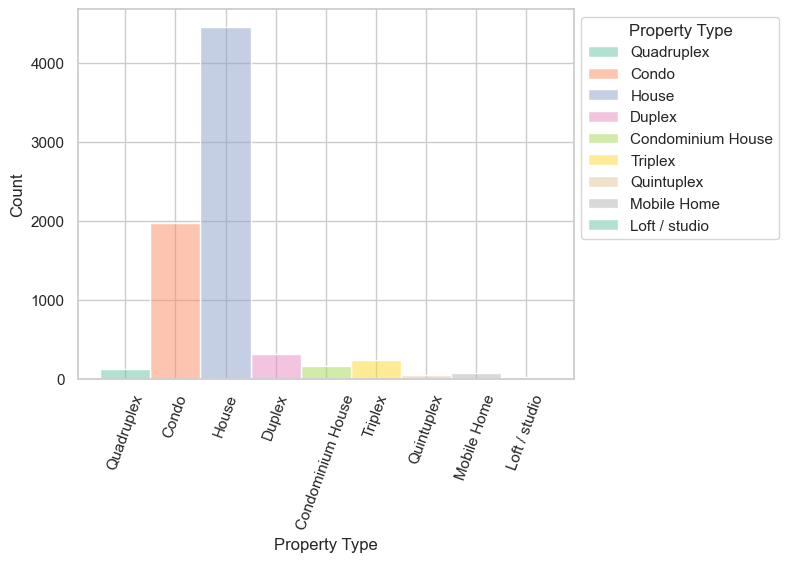

In [217]:
sns.set(style="whitegrid")
g = sns.histplot(data = df, x=df['Property Type'], hue= df['Property Type'], palette='Set2')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=70)
plt.show();

## Count Plot - Number of Listed Properties under 1 Million CAD

In [219]:
df_under_1m =  df[df['Buy Price']<1000000]

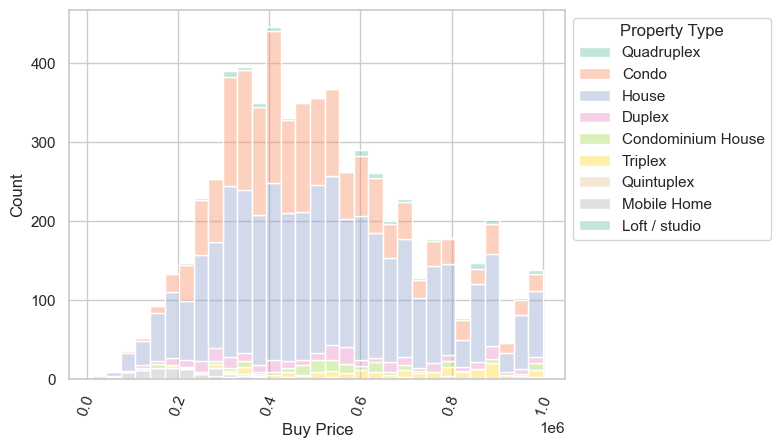

In [220]:
g = sns.histplot(data = df_under_1m, x=df_under_1m['Buy Price'], hue= df['Property Type'], multiple='stack', palette='Set2',alpha=0.4)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=70)
plt.show();

## Lmplots - Relationship Between Numerical Values VS Price

<Figure size 500x400 with 0 Axes>

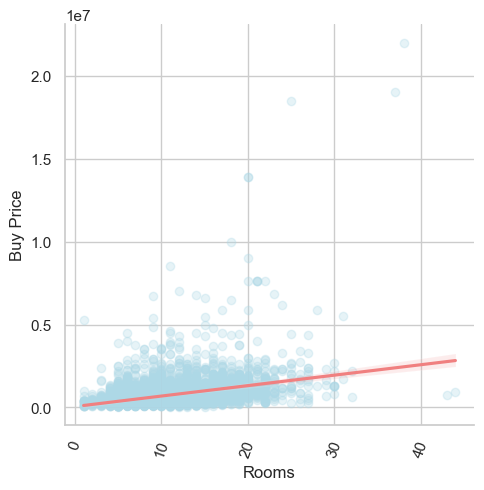

<Figure size 500x400 with 0 Axes>

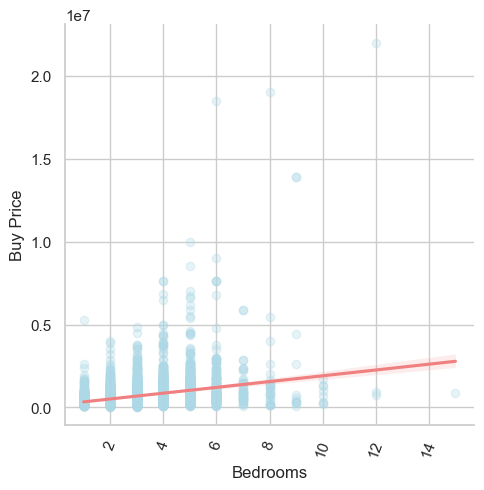

<Figure size 500x400 with 0 Axes>

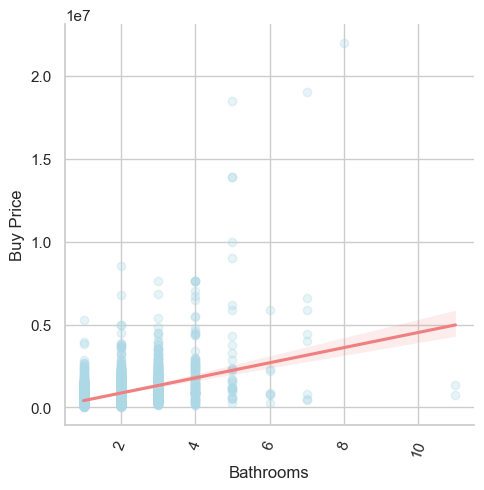

<Figure size 500x400 with 0 Axes>

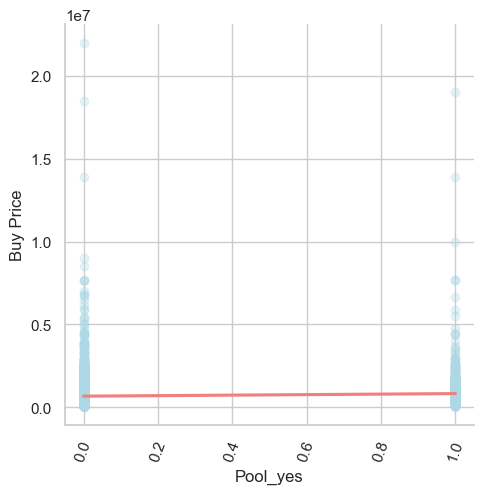

<Figure size 500x400 with 0 Axes>

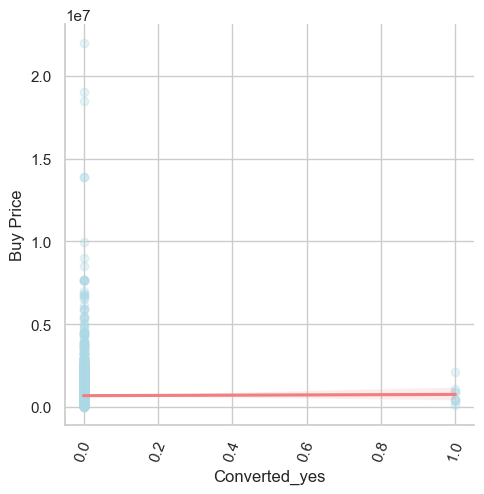

<Figure size 500x400 with 0 Axes>

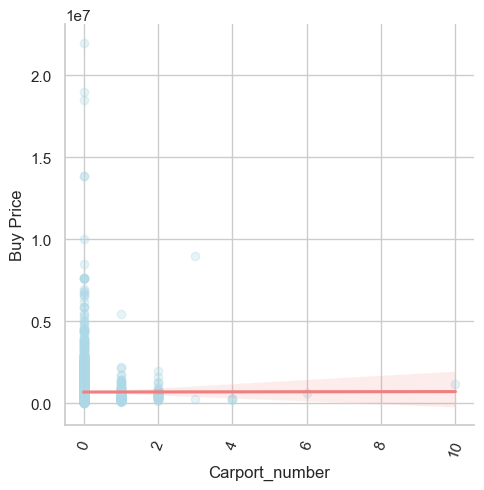

<Figure size 500x400 with 0 Axes>

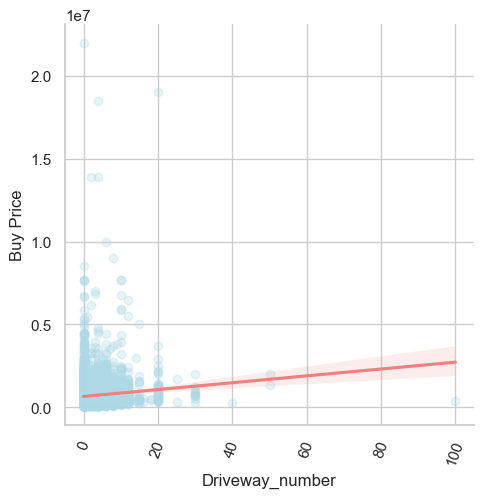

<Figure size 500x400 with 0 Axes>

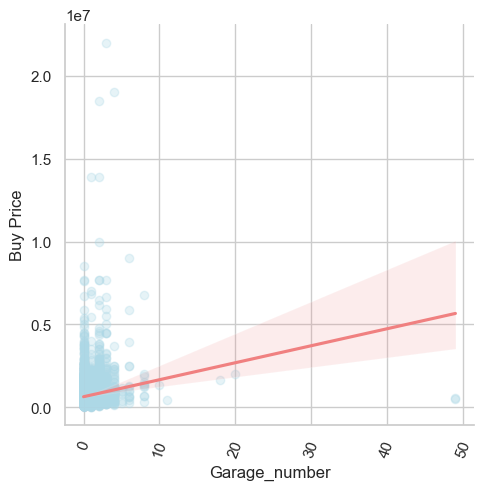

<Figure size 500x400 with 0 Axes>

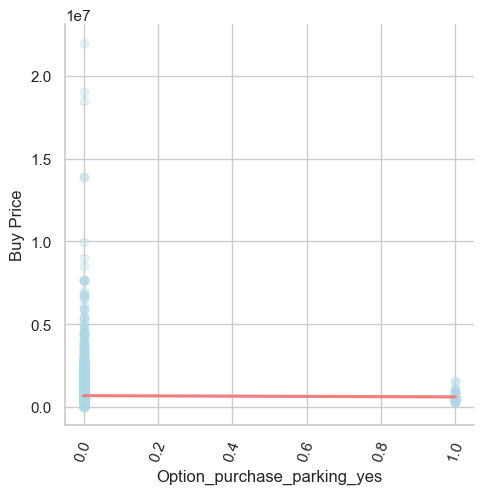

<Figure size 500x400 with 0 Axes>

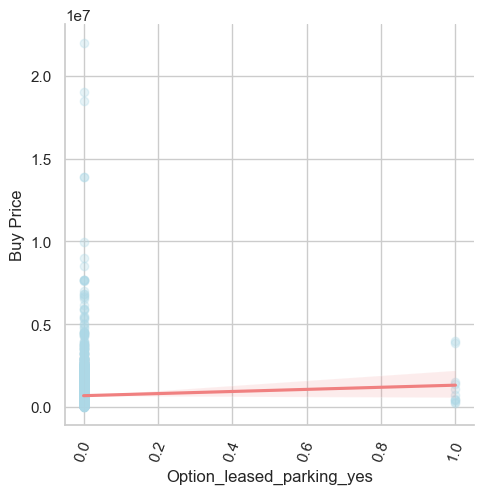

In [224]:
sns.set(style="whitegrid")
for col in df.drop('Buy Price',axis=1).select_dtypes(include="int64"):
    plt.figure(figsize=(5,4))
    sns.lmplot(data=df,x=col,y='Buy Price',scatter_kws={"color":"lightblue",'alpha':0.3},line_kws={"color":"lightcoral"})
    plt.xticks(rotation=70)
    plt.show()

## Catplots - Mean Prices Based on Each Categorical Values

<Figure size 800x600 with 0 Axes>

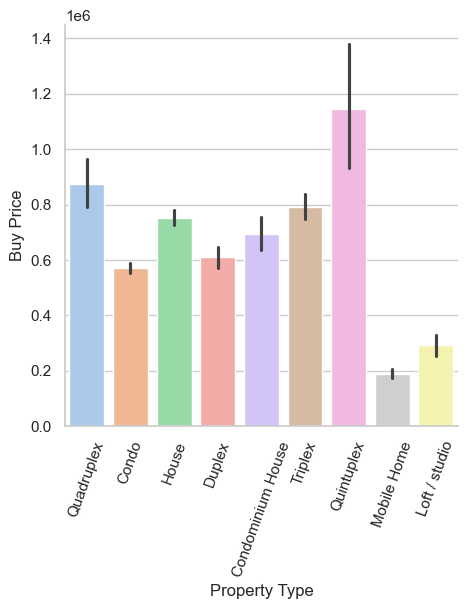

<Figure size 800x600 with 0 Axes>

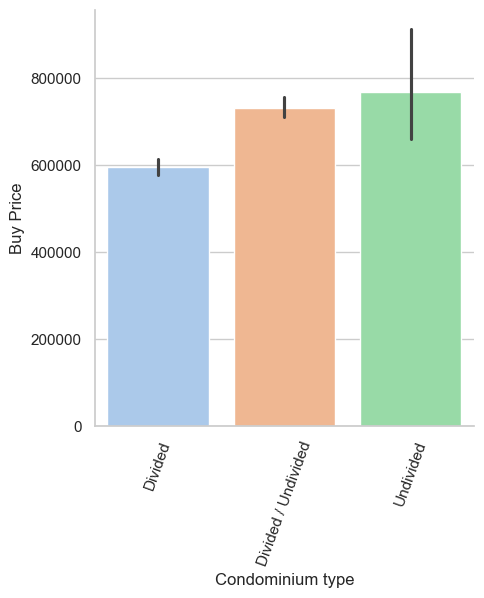

<Figure size 800x600 with 0 Axes>

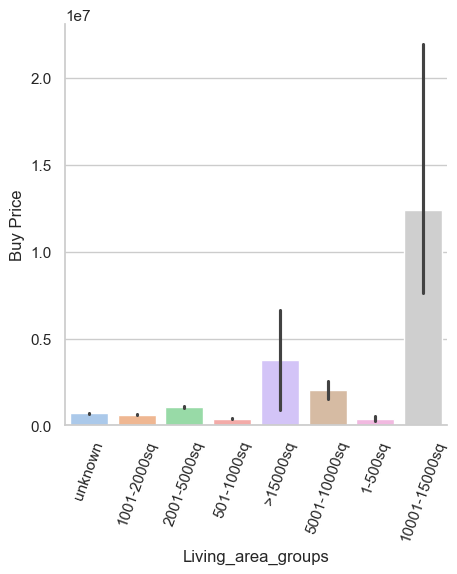

<Figure size 800x600 with 0 Axes>

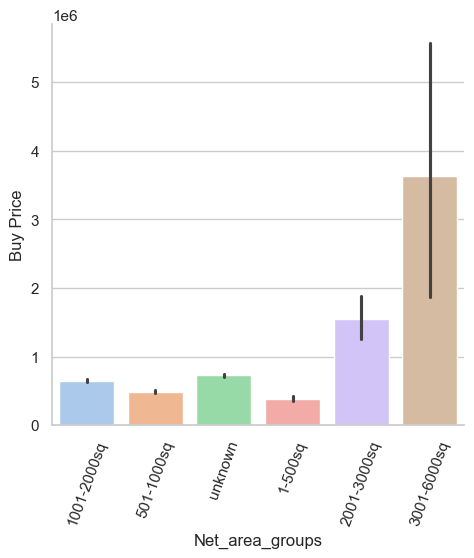

<Figure size 800x600 with 0 Axes>

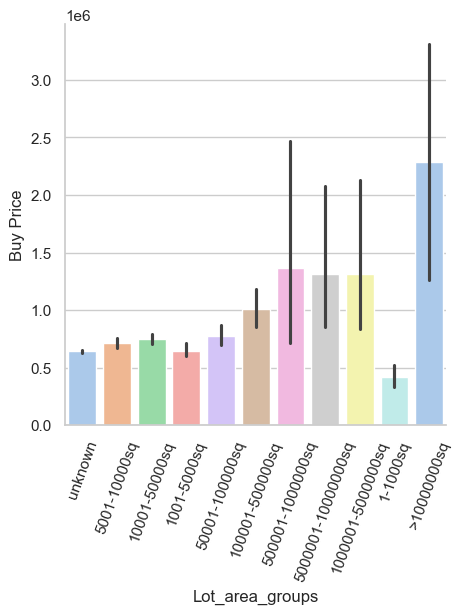

<Figure size 800x600 with 0 Axes>

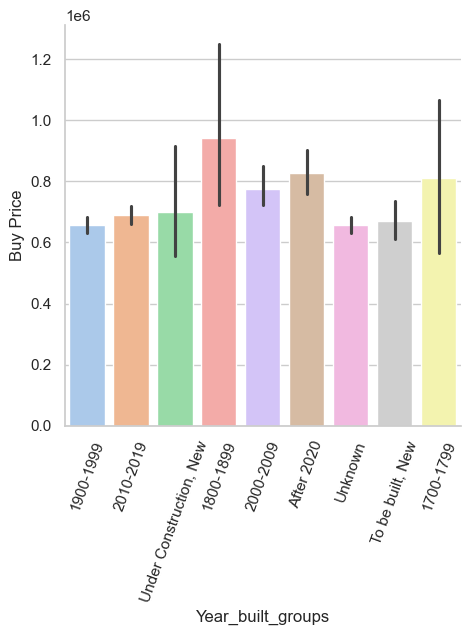

In [227]:
for col in df.drop('Buy Price',axis=1).select_dtypes(include="object"):
    plt.figure(figsize=(8,6))
    g = sns.catplot(data=df,x=col,y='Buy Price',kind="bar",hue=col, palette='pastel')
    plt.xticks(rotation=70)
    plt.show()

### Lmplots - Relationship Between Bathrooms VS Price (Segmented by Categories)

<Figure size 800x600 with 0 Axes>

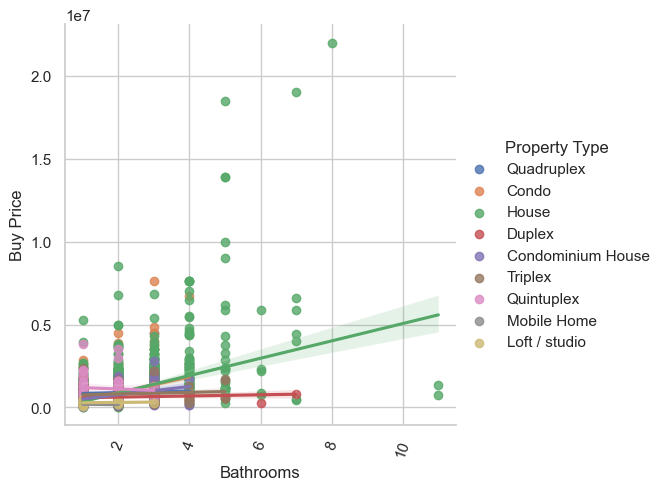

<Figure size 800x600 with 0 Axes>

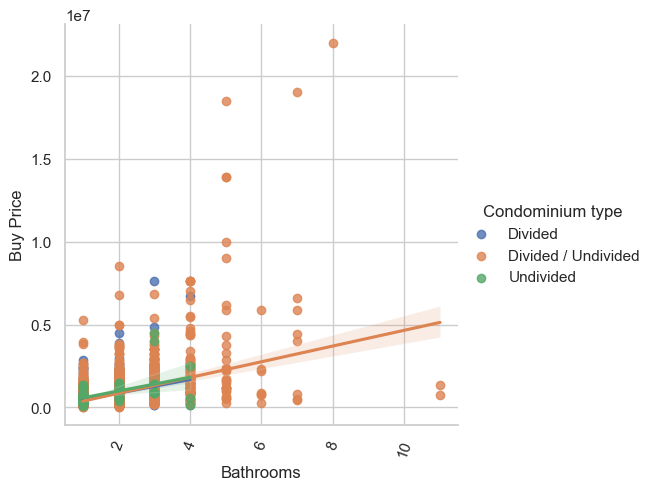

<Figure size 800x600 with 0 Axes>

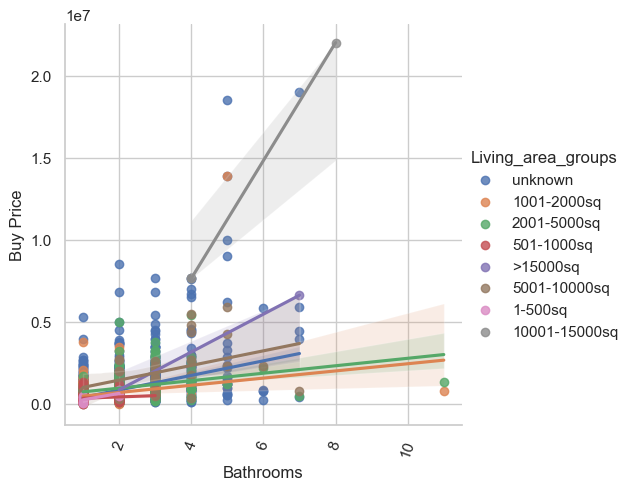

<Figure size 800x600 with 0 Axes>

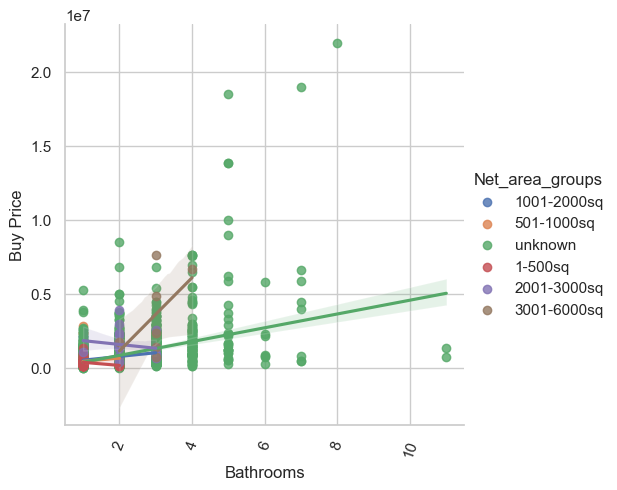

<Figure size 800x600 with 0 Axes>

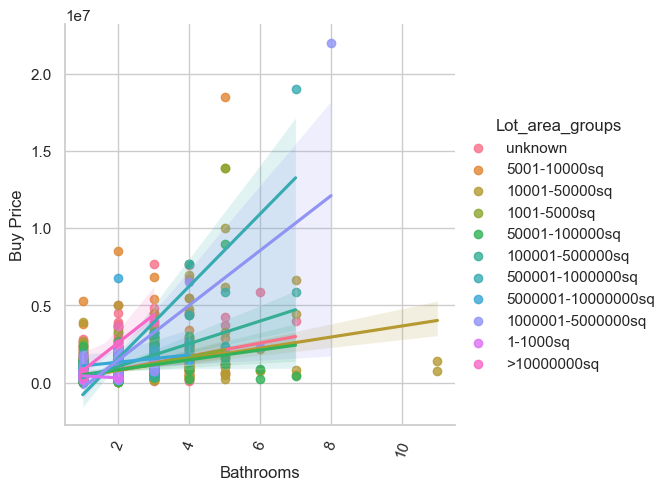

<Figure size 800x600 with 0 Axes>

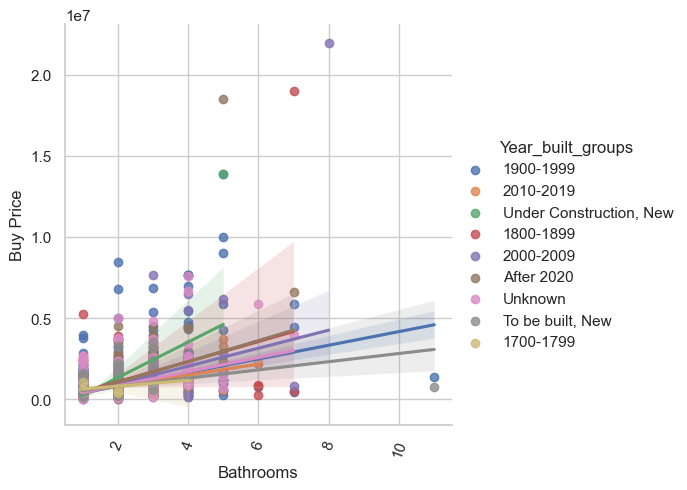

In [230]:
for col in df.drop('Buy Price',axis=1).select_dtypes(include="object"):
    plt.figure(figsize=(8,6))
    g = sns.lmplot(data=df,x='Bathrooms',y='Buy Price',hue=col)
    plt.xticks(rotation=70)
    plt.show()

## Heatmap - Correlation of Numerical Variables

In [233]:
df_corr = df.corr(numeric_only=True)

<Axes: >

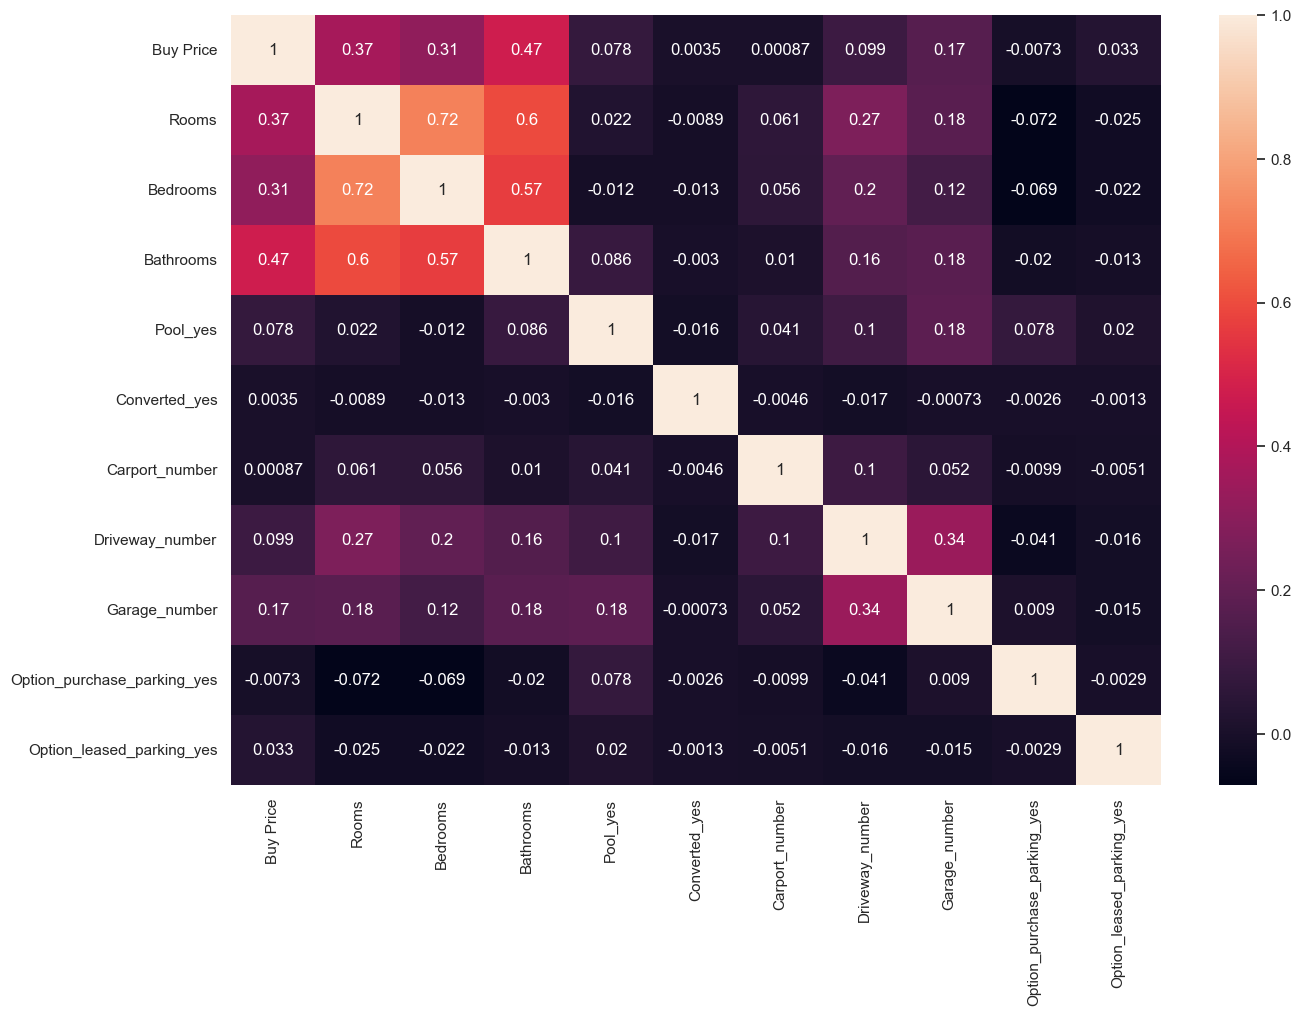

In [235]:
plt.figure(figsize=[15,10])
sns.heatmap(df_corr,annot=True)

Hgih corelations with Price: Bathrooms, Rooms, Bedrooms, Garage_number

## Clustermap - Correlation of Numerical Variables + Hierarchical Clustering

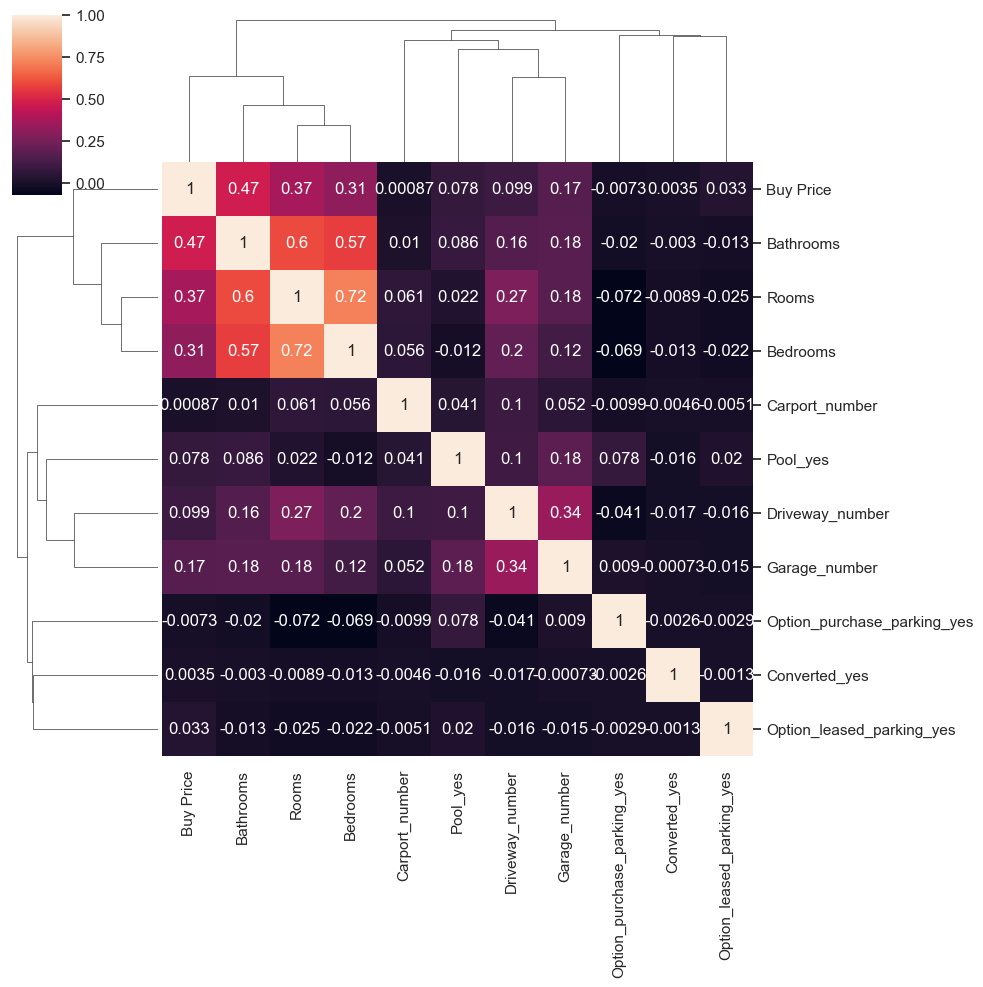

In [239]:
sns.clustermap(df_corr,annot=True)

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part V - Statistical Analysis</b></h2>

## Statsmodel

In [14]:
df_all = pd.read_csv("cleaned_property_dataset.csv")

In [243]:
df = df_all.drop(["Address","Region"], axis=1)

In [245]:
df.corr(numeric_only=True)

Buy Price     Rooms  Bedrooms  Bathrooms  \
Buy Price                     1.000000  0.369628  0.314243   0.474260   
Rooms                         0.369628  1.000000  0.718035   0.597612   
Bedrooms                      0.314243  0.718035  1.000000   0.566747   
Bathrooms                     0.474260  0.597612  0.566747   1.000000   
Pool_yes                      0.077783  0.021659 -0.011694   0.086437   
Converted_yes                 0.003501 -0.008948 -0.012923  -0.002978   
Carport_number                0.000868  0.061202  0.055695   0.010483   
Driveway_number               0.098878  0.269650  0.198455   0.158875   
Garage_number                 0.170412  0.177565  0.117116   0.179195   
Option_purchase_parking_yes  -0.007254 -0.071654 -0.069191  -0.019871   
Option_leased_parking_yes     0.032583 -0.025031 -0.022380  -0.012797   

                             Pool_yes  Converted_yes  Carport_number  \
Buy Price                    0.077783       0.003501        0.000868   
Rooms                        0.021659      -0.008948        0.061202   
Bedrooms                    -0.011694      -0.012923        0.055695   
Bathrooms                    0.086437      -0.002978        0.010483   
Pool_yes                     1.000000      -0.015684        0.041277   
Converted_yes               -0.015684       1.000000       -0.004615   
Carport_number               0.041277      -0.004615        1.000000   
Driveway_number              0.104915      -0.016597        0.103558   
Garage_number                0.184073      -0.000726        0.051613   
Option_purchase_parking_yes  0.078134      -0.002596       -0.009870   
Option_leased_parking_yes    0.020081      -0.001342       -0.005102   

                             Driveway_number  Garage_number  \
Buy Price                           0.098878       0.170412   
Rooms                               0.269650       0.177565   
Bedrooms                            0.198455       0.117116   
Bathrooms                           0.158875       0.179195   
Pool_yes                            0.104915       0.184073   
Converted_yes                      -0.016597      -0.000726   
Carport_number                      0.103558       0.051613   
Driveway_number                     1.000000       0.340454   
Garage_number                       0.340454       1.000000   
Option_purchase_parking_yes        -0.041427       0.008995   
Option_leased_parking_yes          -0.016068      -0.015186   

                             Option_purchase_parking_yes  \
Buy Price                                      -0.007254   
Rooms                                          -0.071654   
Bedrooms                                       -0.069191   
Bathrooms                                      -0.019871   
Pool_yes                                        0.078134   
Converted_yes                                  -0.002596   
Carport_number                                 -0.009870   
Driveway_number                                -0.041427   
Garage_number                                   0.008995   
Option_purchase_parking_yes                     1.000000   
Option_leased_parking_yes                      -0.002871   

                             Option_leased_parking_yes  
Buy Price                                     0.032583  
Rooms                                        -0.025031  
Bedrooms                                     -0.022380  
Bathrooms                                    -0.012797  
Pool_yes                                      0.020081  
Converted_yes                                -0.001342  
Carport_number                               -0.005102  
Driveway_number                              -0.016068  
Garage_number                                -0.015186  
Option_purchase_parking_yes                  -0.002871  
Option_leased_parking_yes                     1.000000

Most imporatnt feature:
- Bathrooms
- Rooms
- Bedrooms
- Garage_number
- Driveway_number
- Pool_yes

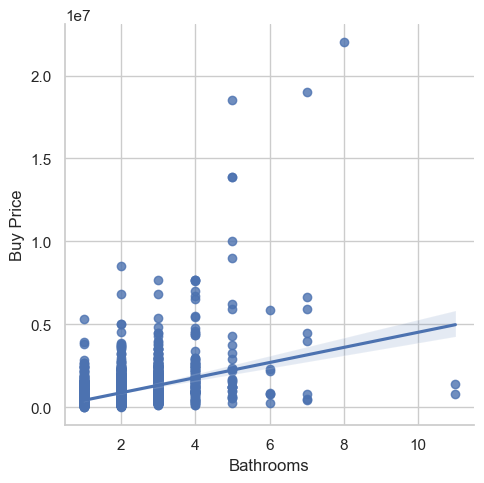

In [248]:
sns.lmplot(df, x='Bathrooms', y='Buy Price')

## Try Using One feature

In [251]:
X = df['Bathrooms']
y = df['Buy Price']

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     2154.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:27:48   Log-Likelihood:            -1.1001e+05
No. Observations:                7424   AIC:                         2.200e+05
Df Residuals:                    7422   BIC:                         2.200e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.58e+04   1.77e+04     -2.588      0.010   -8.05e+04   -1.11e+04
Bathrooms   4.566e+05   9838.653     46.409      0.000    4.37e+05    4.76e+05
==============================================================================
Omnibus:                    12049.926   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14866371.258
Skew:                          10.431   Prob(JB):                         0.00
Kurtosis:                     221.230   Cond. No.                         5.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: ylabel='None'>

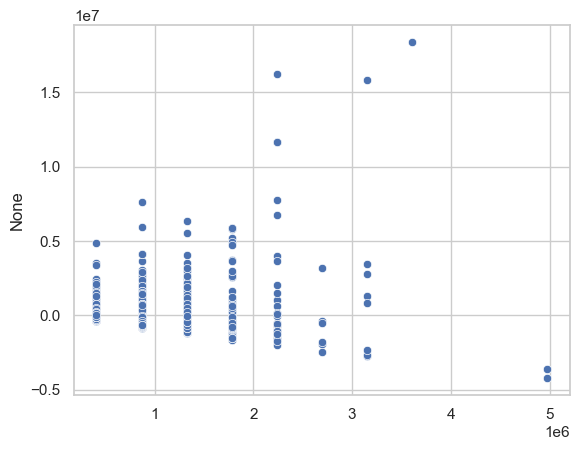

In [253]:
sns.scatterplot(x=model.predict(), y=model.resid)

## Try Adding Polynomial Features

In [256]:
df = df.assign(bathroom_sq = df['Bathrooms']**2)

X = sm.add_constant(df[['Bathrooms', 'bathroom_sq']])
y = df['Buy Price']

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     1173.
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:27:49   Log-Likelihood:            -1.0993e+05
No. Observations:                7424   AIC:                         2.199e+05
Df Residuals:                    7421   BIC:                         2.199e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.982e+05   2.66e+04      7.452      0.000    1.46e+05     2.5e+05
Bathrooms    2.004e+05   2.32e+04      8.657      0.000    1.55e+05    2.46e+05
bathroom_sq  5.301e+04   4346.475     12.197      0.000    4.45e+04    6.15e+04
==============================================================================
Omnibus:                    11162.726   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11103794.972
Skew:                           8.927   Prob(JB):                         0.00
Kurtosis:                     191.619   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: ylabel='None'>

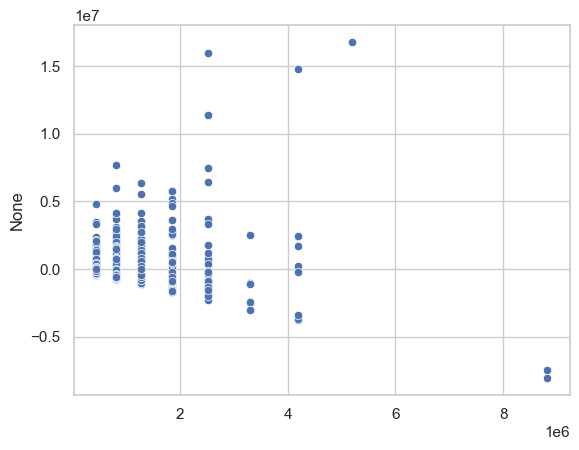

In [258]:
sns.scatterplot(x=model.predict(), y=model.resid)

## Using Multiple Features (Except Regions)

In [261]:
X = df.drop('Buy Price', axis=1)

y = df['Buy Price']

X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

model.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_16124/3751834922.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     83.51
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:27:51   Log-Likelihood:            -1.0926e+05
No. Observations:                7424   AIC:                         2.186e+05
Df Residuals:                    7372   BIC:                         2.190e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      -1.56e+05   3.65e+05     -0.427      0.669   -8.72e+05     5.6e+05
Rooms                                      2.516e+04   2581.244      9.748      0.000    2.01e+04    3.02e+04
Bedrooms                                   1.459e+04   8257.548      1.767      0.077   -1597.814    3.08e+04
Bathrooms                                  1.098e+05   2.35e+04      4.669      0.000    6.37e+04    1.56e+05
Pool_yes                                   4.478e+04      2e+04      2.234      0.026    5485.933    8.41e+04
Converted_yes                             -1.493e+04   2.04e+05     -0.073      0.942   -4.16e+05    3.86e+05
Carport_number                            -3.079e+04   2.72e+04     -1.133      0.257   -8.41e+04    2.25e+04
Driveway_number                           -4670.0430   2562.542     -1.822      0.068   -9693.358     353.272
Garage_number                              4.103e+04   6239.246      6.576      0.000    2.88e+04    5.33e+04
Option_purchase_parking_yes               -1.019e+05   9.72e+04     -1.048      0.295   -2.92e+05    8.87e+04
Option_leased_parking_yes                   6.46e+05   1.82e+05      3.548      0.000    2.89e+05       1e+06
bathroom_sq                                4.208e+04   4110.297     10.237      0.000     3.4e+04    5.01e+04
Property Type_Condominium House           -1.089e+05   5.35e+04     -2.036      0.042   -2.14e+05   -4064.142
Property Type_Duplex                      -1.013e+05    4.1e+04     -2.469      0.014   -1.82e+05   -2.09e+04
Property Type_House                        2.951e+04    3.1e+04      0.952      0.341   -3.13e+04    9.03e+04
Property Type_Loft / studio               -1.203e+05   1.23e+05     -0.978      0.328   -3.62e+05    1.21e+05
Property Type_Mobile Home                 -1.076e+05   7.34e+04     -1.468      0.142   -2.51e+05    3.61e+04
Property Type_Quadruplex                   2.159e+05   5.74e+04      3.762      0.000    1.03e+05    3.28e+05
Property Type_Quintuplex                   4.605e+05   9.06e+04      5.082      0.000    2.83e+05    6.38e+05
Property Type_Triplex                      1.252e+05   4.55e+04      2.750      0.006    3.59e+04    2.14e+05
Condominium type_Divided / Undivided      -1.197e+05   3.93e+04     -3.046      0.002   -1.97e+05   -4.27e+04
Condominium type_Undivided                 1.194e+05   6.43e+04      1.858      0.063   -6566.969    2.45e+05
Living_area_groups_10001-15000sq           9.602e+06   4.01e+05     23.939      0.000    8.82e+06    1.04e+07
Living_area_groups_1001-2000sq             8.413e+04   1.91e+05      0.441      0.659    -2.9e+05    4.58e+05
Living_area_groups_2001-5000sq             1.541e+05   1.93e+05      0.800      0.424   -2.23e+05    5.32e+05
Liv

## Using Bathroom_sq + Region Feature

In [263]:
df_trial_1 = df_all.assign(bathroom_sq = df_all['Bathrooms']**2).drop('Address',axis=1)

In [267]:
X = df_trial_1[['bathroom_sq','Region']] 

y = df_trial_1['Buy Price']

X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

model.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_16124/3395551379.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     5.918
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:28:21   Log-Likelihood:            -1.0834e+05
No. Observations:                7424   AIC:                         2.189e+05
Df Residuals:                    6332   BIC:                         2.264e+05
Df Model:                        1091                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                          1.311e+05   2.02e+05      0.649      0.516   -2.65e+05    5.27e+05
bathroom_sq                                                    7.994e+04   1937.282     41.264      0.000    7.61e+04    8.37e+04
Region_Aguanish                                                3.794e+04   6.05e+05      0.063      0.950   -1.15e+06    1.22e+06
Region_Amherst                                                 1.626e+05   2.85e+05      0.570      0.569   -3.97e+05    7.22e+05
Region_Amqui                                                  -9.147e+04   4.51e+05     -0.203      0.839   -9.76e+05    7.93e+05
Region_Ange-Gardien                                            2.648e+05   3.49e+05      0.758      0.449    -4.2e+05     9.5e+05
Region_Armagh                                                 -2.616e+04   6.05e+05     -0.043      0.966   -1.21e+06    1.16e+06
Region_Arundel                                                 2.794e+04   6.05e+05      0.046      0.963   -1.16e+06    1.21e+06
Region_Ascot Corner                                            4.047e+05   3.86e+05      1.048      0.295   -3.53e+05    1.16e+06
Region_Auclair                                                -3.709e+05   6.05e+05     -0.613      0.540   -1.56e+06    8.15e+05
Region_Audet                                                  -2.159e+05   6.05e+05     -0.357      0.721    -1.4e+06     9.7e+05
Region_Aumond                                                  1.571e+05   4.51e+05      0.348      0.728   -7.27e+05    1.04e+06
Region_Austin                                                  5.015e+05   3.49e+05      1.435      0.151   -1.83e+05    1.19e+06
Region_Ayer's Cliff                                            2.383e+05   3.86e+05      0.617      0.537   -5.19e+05    9.96e+05
Region_Baie-Saint-Paul                                         3.632e+04   2.45e+05      0.148      0.882   -4.43e+05    5.16e+05
Region_Baie-Trinité                                           -2.014e+05   6.05e+05     -0.333      0.739   -1.39e+06    9.85e+05
Region_Barraute                                                9.527e+04   3.86e+05      0.247      0.805   -6.62e+05    8.53e+05
Region_Beauceville                                            -5.137e+04   3.86e+05     -0.133      0.894   -8.09e+05    7.06e+05
Region_Beaulac-Garthby                                         2.915e+05   4.51e+05      0.646      0.518   -5.93e+05    1.18e+06
Region_Beaumont                                                9.233e+04   2.85e+05      0.324      0.746   -4.67e+05    6.52e+05
Region_Beaupré                                                 1.122e+04   2.65e+05      0.04

<Axes: ylabel='None'>

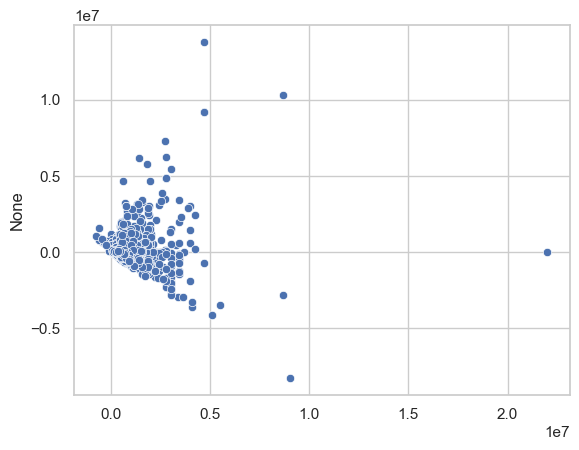

In [268]:
sns.scatterplot(x=model.predict(), y=model.resid)

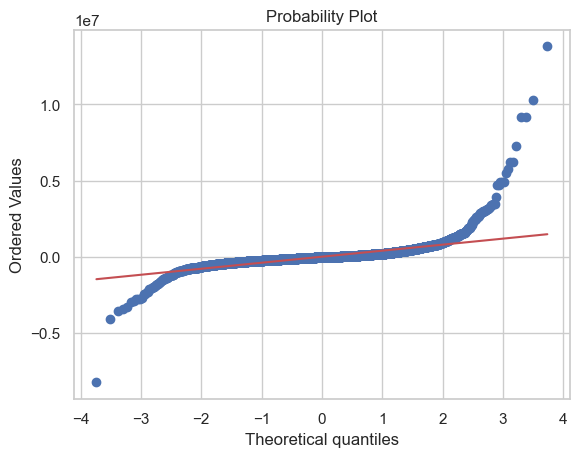

In [269]:
# QQ Plot with residuals

import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(model.resid, dist="norm", plot=plt);

## Using Bathrooms_sq + Other Features + Region Feature

In [252]:
df_trial_2 = df_all.assign(bathroom_sq = df_all['Bathrooms']**2).drop('Address',axis=1)

X = df_trial_2.drop(['Bathrooms','Buy Price'],axis=1)

y = df_trial_2['Buy Price']

X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

model.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_22814/411948065.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     7.801
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        02:58:36   Log-Likelihood:            -1.0768e+05
No. Observations:                7424   AIC:                         2.176e+05
Df Residuals:                    6283   BIC:                         2.255e+05
Df Model:                        1140                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                         -8.842e+05   4.27e+05     -2.070      0.038   -1.72e+06    -4.7e+04
Rooms                                                          2.578e+04   2563.739     10.055      0.000    2.08e+04    3.08e+04
Bedrooms                                                       1.131e+04   8207.744      1.378      0.168   -4776.578    2.74e+04
Pool_yes                                                       7949.2480   1.92e+04      0.415      0.678   -2.96e+04    4.55e+04
Converted_yes                                                 -1.839e+05   1.85e+05     -0.994      0.320   -5.47e+05    1.79e+05
Carport_number                                                -1.358e+04   2.65e+04     -0.513      0.608   -6.55e+04    3.84e+04
Driveway_number                                                1872.5945   2535.125      0.739      0.460   -3097.117    6842.306
Garage_number                                                  2.864e+04   5947.891      4.815      0.000     1.7e+04    4.03e+04
Option_purchase_parking_yes                                   -1.287e+05   8.82e+04     -1.460      0.144   -3.01e+05    4.41e+04
Option_leased_parking_yes                                      5.397e+05   1.63e+05      3.303      0.001    2.19e+05     8.6e+05
bathroom_sq                                                    5.032e+04   2229.483     22.569      0.000    4.59e+04    5.47e+04
Property Type_Condominium House                                9.916e+04   5.05e+04      1.962      0.050      79.196    1.98e+05
Property Type_Duplex                                           1.914e+05   4.04e+04      4.735      0.000    1.12e+05    2.71e+05
Property Type_House                                            3.876e+05   3.25e+04     11.936      0.000    3.24e+05    4.51e+05
Property Type_Loft / studio                                   -1.047e+05   1.11e+05     -0.941      0.347   -3.23e+05    1.13e+05
Property Type_Mobile Home                                      3.206e+05   8.25e+04      3.888      0.000    1.59e+05    4.82e+05
Property Type_Quadruplex                                       5.346e+05   5.55e+04      9.626      0.000    4.26e+05    6.43e+05
Property Type_Quintuplex                                        7.28e+05   8.75e+04      8.321      0.000    5.56e+05    8.99e+05
Property Type_Triplex                                          4.074e+05   4.47e+04      9.113      0.000     3.2e+05    4.95e+05
Condominium type_Divided / Undivided                          -1.106e+05   3.62e+04     -3.058      0.002   -1.81e+05   -3.97e+04
Condominium type_Undivided                                    -1.167e+05   6.03e+04     -1.93

## Try Converting More Numerical Features into Polynomial Features + Region Feature

In [262]:
df_trial_3 = df_all.assign(bathroom_sq = df_all['Bathrooms']**2,
                          rooms_sq = df_all['Rooms']**2,
                          bedrooms_sq = df_all['Bedrooms']**2,
                          driveway_number_sq = df_all['Driveway_number']**2,
                          garage_number_sq = df_all['Garage_number']**2).drop('Address',axis=1)

X = df_trial_3.drop(['Bathrooms','Rooms','Bedrooms','Driveway_number','Garage_number','Buy Price'],axis=1)

y = df_trial_3['Buy Price']

X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

model.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_22814/1568614848.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     7.767
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        03:09:33   Log-Likelihood:            -1.0769e+05
No. Observations:                7424   AIC:                         2.177e+05
Df Residuals:                    6283   BIC:                         2.255e+05
Df Model:                        1140                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                         -7.958e+05   4.28e+05     -1.862      0.063   -1.63e+06    4.22e+04
Pool_yes                                                       1.793e+04   1.91e+04      0.940      0.347   -1.95e+04    5.53e+04
Converted_yes                                                 -1.855e+05   1.85e+05     -1.001      0.317   -5.49e+05    1.78e+05
Carport_number                                                -8685.3727   2.65e+04     -0.328      0.743   -6.07e+04    4.33e+04
Option_purchase_parking_yes                                   -1.315e+05   8.83e+04     -1.491      0.136   -3.05e+05    4.15e+04
Option_leased_parking_yes                                      5.277e+05   1.64e+05      3.227      0.001    2.07e+05    8.48e+05
bathroom_sq                                                    4.893e+04   2316.338     21.122      0.000    4.44e+04    5.35e+04
rooms_sq                                                       1040.6249     91.042     11.430      0.000     862.152    1219.098
bedrooms_sq                                                     738.2237    953.455      0.774      0.439   -1130.875    2607.322
driveway_number_sq                                              -10.3358     50.631     -0.204      0.838    -109.589      88.918
garage_number_sq                                                102.0936    159.318      0.641      0.522    -210.224     414.411
Property Type_Condominium House                                1.284e+05   5.02e+04      2.556      0.011    2.99e+04    2.27e+05
Property Type_Duplex                                           2.145e+05   4.03e+04      5.319      0.000    1.35e+05    2.93e+05
Property Type_House                                            4.098e+05    3.2e+04     12.801      0.000    3.47e+05    4.73e+05
Property Type_Loft / studio                                   -1.251e+05   1.11e+05     -1.125      0.261   -3.43e+05    9.28e+04
Property Type_Mobile Home                                      3.008e+05   8.25e+04      3.646      0.000    1.39e+05    4.63e+05
Property Type_Quadruplex                                       5.557e+05   5.55e+04     10.018      0.000    4.47e+05    6.64e+05
Property Type_Quintuplex                                       7.424e+05   8.75e+04      8.482      0.000    5.71e+05    9.14e+05
Property Type_Triplex                                          4.251e+05   4.47e+04      9.508      0.000    3.37e+05    5.13e+05
Condominium type_Divided / Undivided                          -1.058e+05   3.61e+04     -2.934      0.003   -1.77e+05   -3.51e+04
Condominium type_Undivided                                    -1.168e+05   6.04e+04     -1.93

## Try Log Transforming Property Price +  Bathrooms_sq + Other Features (Include Regions)

In [272]:
df_trial_5 = df_all.assign(bathroom_sq = df_all['Bathrooms']**2).drop('Address',axis=1)

X = df_trial_5.drop(['Bathrooms','Buy Price'],axis=1)

y = df_trial_5['Buy Price']

y = np.log(y)

X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})

X = sm.add_constant(X)

model_log = sm.OLS(y,X).fit()

model_log.summary()

/var/folders/qp/ljh_2xf51cg0lybz4xhz9sm00000gn/T/ipykernel_22814/2095936779.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = pd.get_dummies(X, drop_first=True).replace({True:1,False:0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Buy Price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     12.84
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        03:21:28   Log-Likelihood:                -2646.6
No. Observations:                7424   AIC:                             7575.
Df Residuals:                    6283   BIC:                         1.546e+04
Df Model:                        1140                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
const                                                            11.2850      0.306     36.839      0.000      10.685      11.886
Rooms                                                             0.0353      0.002     19.196      0.000       0.032       0.039
Bedrooms                                                          0.0183      0.006      3.116      0.002       0.007       0.030
Pool_yes                                                          0.0323      0.014      2.349      0.019       0.005       0.059
Converted_yes                                                    -0.0834      0.133     -0.628      0.530      -0.344       0.177
Carport_number                                                   -0.0387      0.019     -2.035      0.042      -0.076      -0.001
Driveway_number                                                   0.0006      0.002      0.322      0.747      -0.003       0.004
Garage_number                                                     0.0234      0.004      5.487      0.000       0.015       0.032
Option_purchase_parking_yes                                      -0.0856      0.063     -1.354      0.176      -0.210       0.038
Option_leased_parking_yes                                         0.3779      0.117      3.225      0.001       0.148       0.608
bathroom_sq                                                       0.0234      0.002     14.624      0.000       0.020       0.027
Property Type_Condominium House                                   0.2097      0.036      5.783      0.000       0.139       0.281
Property Type_Duplex                                              0.3108      0.029     10.717      0.000       0.254       0.368
Property Type_House                                               0.5001      0.023     21.474      0.000       0.454       0.546
Property Type_Loft / studio                                      -0.3227      0.080     -4.047      0.000      -0.479      -0.166
Property Type_Mobile Home                                        -0.1605      0.059     -2.713      0.007      -0.276      -0.045
Property Type_Quadruplex                                          0.7438      0.040     18.671      0.000       0.666       0.822
Property Type_Quintuplex                                          0.8601      0.063     13.708      0.000       0.737       0.983
Property Type_Triplex                                             0.6257      0.032     19.513      0.000       0.563       0.689
Condominium type_Divided / Undivided                             -0.1219      0.026     -4.699      0.000      -0.173      -0.071
Condominium type_Undivided                                       -0.0330      0.043     -0.76

<Axes: ylabel='None'>

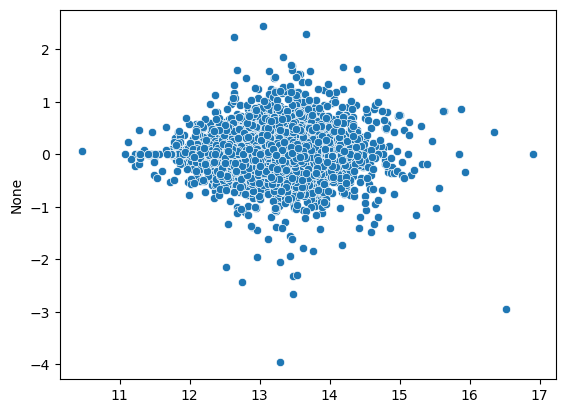

In [274]:
sns.scatterplot(x=model_log.predict(), y=model.resid)

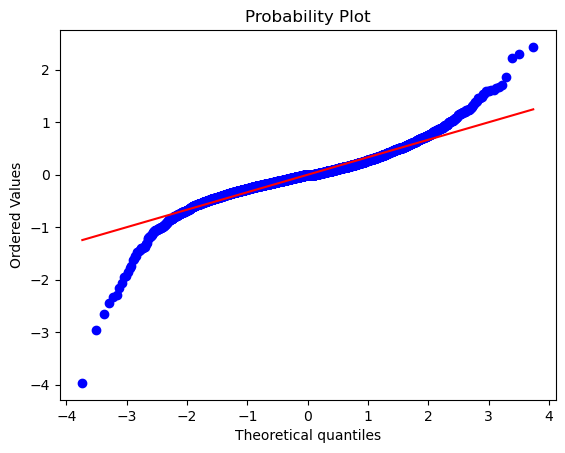

In [276]:
# QQ Plot with residuals

import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(model_log.resid, dist="norm", plot=plt);

## Important Features

## Use SelectK chi2 square to select the best categorical columns

In [227]:
df_chi2 = df_all.drop("Address", axis=1)

cat_columns = ['Property Type', 'Condominium type', 'Living_area_groups',
       'Net_area_groups', 'Lot_area_groups', 'Region', 'Year_built_groups']

df_dummies_chi2 = pd.get_dummies(df_chi2, columns=cat_columns, drop_first=True)

# Separate features and target variable
X = df_dummies_chi2.drop(['Buy Price', 'Rooms', 'Bedrooms', 'Bathrooms', 'Pool_yes',
                          'Converted_yes', 'Carport_number', 'Driveway_number', 'Garage_number',
                          'Option_purchase_parking_yes', 'Option_leased_parking_yes'],axis=1)
y = df_dummies_chi2['Buy Price']

# Split data into train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

from sklearn.feature_selection import SelectKBest, chi2

# Initialize SelectKBest with chi2, choose top features
selector = SelectKBest(score_func=chi2, k=50)

# Fit and transform training data only
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the selected feature names
selected_features = selector.get_feature_names_out(X.columns)

# View top features
selected_features

array(['Living_area_groups_10001-15000sq', 'Region_Armagh',
       'Region_Auclair', 'Region_Biencourt', 'Region_Champneuf',
       'Region_East Hereford', 'Region_Eeyou Istchee Baie-James',
       'Region_Fortierville', 'Region_Ivry-sur-le-Lac',
       "Region_Kinnear's Mills", 'Region_Laurier-Station',
       'Region_Laval (Laval-sur-le-Lac)', 'Region_Montcalm',
       'Region_Montebello', 'Region_Neighbourhood Beaudry',
       'Region_Neighbourhood Gracefield (centre)',
       "Region_Neighbourhood L'Arrondissement",
       'Region_Neighbourhood La Briqueterie',
       'Region_Neighbourhood Lac-des-Loups',
       'Region_Neighbourhood Northfield',
       'Region_Neighbourhood Petite-Bourgogne',
       'Region_Neighbourhood Saint-Georges-Malbaie',
       'Region_Neighbourhood Sainte-Geneviève',
       'Region_Neighbourhood Sherwood (North West)',
       'Region_Neighbourhood Val-Paradis',
       'Region_Neighbourhood Val-Tétreau',
       'Region_Neighbourhood Vaudreuil West', 'Region

### Use SelectK chi2 square to select the best categorical columns

In [231]:
df_chi2_2 = df_all.drop(["Address","Region"], axis=1)

cat_columns = ['Property Type', 'Condominium type', 'Living_area_groups',
       'Net_area_groups', 'Lot_area_groups', 'Year_built_groups']

df_dummies_chi2_2 = pd.get_dummies(df_chi2_2, columns=cat_columns, drop_first=True)

# Separate features and target variable
X = df_dummies_chi2_2.drop(['Buy Price', 'Rooms', 'Bedrooms', 'Bathrooms', 'Pool_yes',
                          'Converted_yes', 'Carport_number', 'Driveway_number', 'Garage_number',
                          'Option_purchase_parking_yes', 'Option_leased_parking_yes'],axis=1)
y = df_dummies_chi2_2['Buy Price']

# Split data into train-test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

from sklearn.feature_selection import SelectKBest, chi2

# Initialize SelectKBest with chi2, choose top features
selector_2 = SelectKBest(score_func=chi2, k=10)

# Fit and transform training data only
X_train_selected = selector_2.fit_transform(X_train, y_train)

# Get the selected feature names
selected_features_2 = selector_2.get_feature_names_out(X.columns)

# View top features
selected_features_2

array(['Property Type_Mobile Home', 'Property Type_Quintuplex',
       'Living_area_groups_10001-15000sq',
       'Living_area_groups_5001-10000sq', 'Living_area_groups_>15000sq',
       'Net_area_groups_2001-3000sq', 'Net_area_groups_3001-6000sq',
       'Lot_area_groups_>10000000sq',
       'Year_built_groups_To be built, New',
       'Year_built_groups_Under Construction, New'], dtype=object)

In [4]:
# This cannot be ran
# Get VIF scores for features
# Ignore VIF for constant

#from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

#pd.Series([vif(X.values, i) for i in range(X.shape[1])],index=X.columns)

In [6]:
#influence = model.get_influence()
#inf_summary_df = influence.summary_frame()
#inf_summary_df.head()

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part VI - Machine Learnning Models </b></h2>

In [3]:
df_all = pd.read_csv("cleaned_property_dataset.csv")

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import RidgeCV, ElasticNet, ElasticNetCV, LassoCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_transformer

## 1. LassoCV Model

In [32]:
df_la = df_all.drop('Address',axis=1)

In [34]:
from sklearn.preprocessing import OrdinalEncoder

#Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[
    ['Mobile Home', 'Loft / studio', 'Condo', 'Condominium House', 'House', 'Duplex', 'Triplex', 'Quadruplex', 'Quintuplex'], 
    ['Unknown', '1700-1799', '1800-1899', '1900-1999', '2010-2019', '2000-2009', 'After 2020','Under Construction, New','To be built, New']])

#Fit and transform the 'beds' and 'baths' columns
df_la[['Property Type', 'Year_built_groups']] = ordinal_encoder.fit_transform(df_la[['Property Type', 'Year_built_groups']])

In [36]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df_la[['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [38]:
df_la = df_la.drop(columns=['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df_la.head(3)

Buy Price  Property Type  Rooms  Bedrooms  Bathrooms  Pool_yes  \
0     649000            7.0      9         2          1         0   
1     365000            2.0      9         2          1         0   
2     399000            2.0      3         1          1         0   

   Converted_yes  Carport_number  Driveway_number  Garage_number  ...  \
0              0               0                1              0  ...   
1              0               0                1              0  ...   
2              0               0                0              0  ...   

   Year_built_groups_1.0  Year_built_groups_2.0  Year_built_groups_3.0  \
0                    0.0                    0.0                    1.0   
1                    0.0                    0.0                    1.0   
2                    0.0                    0.0                    0.0   

   Year_built_groups_4.0  Year_built_groups_5.0  Year_built_groups_6.0  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    1.0                    0.0                    0.0   

   Year_built_groups_7.0  Year_built_groups_8.0  \
0                    0.0                    0.0   
1                    0.0                    0.0   
2                    0.0                    0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1134 columns]

In [40]:
X = df_la.drop('Buy Price',axis=1)
y = df_la['Buy Price']

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [42]:
X.shape

(7424, 1133)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
from sklearn.linear_model import LassoCV

lassocv_model = LassoCV(eps=0.001, n_alphas=100,cv=5)

lassocv_model.fit(X_train_scaled, y_train)


LassoCV(cv=5)

In [47]:
lassocv_model.alpha_

4501.6351657087125

In [48]:
# lassocv coefficients
lassocv_model.coef_

array([ 60179.96616117, 124293.95905506,   1505.4032322 , ...,
         2838.86289303,     -0.        ,     -0.        ])

In [54]:
la_y_train_pred = lassocv_model.predict(X_train_scaled)
la_y_test_pred = lassocv_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2

la_MAE_train= mae(y_train,la_y_train_pred)
la_MSE_train= mse(y_train,la_y_train_pred)
la_RMSE_train= np.sqrt(mse(y_train,la_y_train_pred))
la_r2_train= r2(y_train,la_y_train_pred)

la_MAE_test= mae(y_test,la_y_test_pred)
la_MSE_test= mse(y_test,la_y_test_pred)
la_RMSE_test= np.sqrt(mse(y_test,la_y_test_pred))
la_r2_test= r2(y_test,la_y_test_pred)

df_la_metrics= pd.DataFrame({"LassoCV_train":[la_MAE_train,la_MSE_train,la_RMSE_train,la_r2_train],
                             "LassoCV_test":[la_MAE_test,la_MSE_test,la_RMSE_test,la_r2_test],
                            },index=["MAE","MSE","RMSE","R2_Score"])
df_la_metrics

LassoCV_train  LassoCV_test
MAE        2.425778e+05  2.751661e+05
MSE        2.605054e+11  3.823673e+11
RMSE       5.103973e+05  6.183586e+05
R2_Score   4.998561e-01  4.690822e-01

## 2. RidgeCV Model

## 2.1. RidgeCV Model - First Trial (All Features wihout Address)

In [58]:
df_l2 = df_all.drop('Address',axis=1)

In [60]:
from sklearn.preprocessing import OrdinalEncoder

#Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[
    ['Mobile Home', 'Loft / studio', 'Condo', 'Condominium House', 'House', 'Duplex', 'Triplex', 'Quadruplex', 'Quintuplex'], 
    ['Unknown', '1700-1799', '1800-1899', '1900-1999', '2010-2019', '2000-2009', 'After 2020','Under Construction, New','To be built, New']])

#Fit and transform the 'beds' and 'baths' columns
df_l2[['Property Type', 'Year_built_groups']] = ordinal_encoder.fit_transform(df_l2[['Property Type', 'Year_built_groups']])

In [62]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df_l2[['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [66]:
df_l2 = df_l2.drop(columns=['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df_l2.head(3)

Buy Price  Property Type  Rooms  Bedrooms  Bathrooms  Pool_yes  \
0     649000            7.0      9         2          1         0   
1     365000            2.0      9         2          1         0   
2     399000            2.0      3         1          1         0   

   Converted_yes  Carport_number  Driveway_number  Garage_number  ...  \
0              0               0                1              0  ...   
1              0               0                1              0  ...   
2              0               0                0              0  ...   

   Year_built_groups_1.0  Year_built_groups_2.0  Year_built_groups_3.0  \
0                    0.0                    0.0                    1.0   
1                    0.0                    0.0                    1.0   
2                    0.0                    0.0                    0.0   

   Year_built_groups_4.0  Year_built_groups_5.0  Year_built_groups_6.0  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    1.0                    0.0                    0.0   

   Year_built_groups_7.0  Year_built_groups_8.0  \
0                    0.0                    0.0   
1                    0.0                    0.0   
2                    0.0                    0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1134 columns]

In [68]:
X = df_l2.drop('Buy Price',axis=1)
y = df_l2['Buy Price']

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [72]:
# RidgeCV

ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')

ridge_cv_model.fit(X_train_scaled,y_train)

RidgeCV(scoring='neg_mean_absolute_error')

In [74]:
ridge_cv_model.alpha_

10.0

In [84]:
l2_y_train_pred = ridge_cv_model.predict(X_train_scaled)
l2_y_test_pred = ridge_cv_model.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2

l2_MAE_train= mae(y_train,l2_y_train_pred)
l2_MSE_train= mse(y_train,l2_y_train_pred)
l2_RMSE_train= np.sqrt(mse(y_train,l2_y_train_pred))
l2_r2_train= r2(y_train,l2_y_train_pred)

l2_MAE_test= mae(y_test,l2_y_test_pred)
l2_MSE_test= mse(y_test,l2_y_test_pred)
l2_RMSE_test= np.sqrt(mse(y_test,l2_y_test_pred))
l2_r2_test= r2(y_test,l2_y_test_pred)

df_l2_metrics= pd.DataFrame({"RidgeCV_train":[l2_MAE_train,l2_MSE_train,l2_RMSE_train,l2_r2_train],
                             "RidgeCV_test":[l2_MAE_test,l2_MSE_test,l2_RMSE_test,l2_r2_test],
                            },index=["MAE","MSE","RMSE","R2_Score"])
df_l2_metrics

RidgeCV_train  RidgeCV_test
MAE        2.260300e+05  2.822380e+05
MSE        2.458901e+11  3.858127e+11
RMSE       4.958731e+05  6.211382e+05
R2_Score   5.279159e-01  4.642984e-01

## 2.2. RidgeCV Model - Second Trial (Region + 4 Features) (Without Address)

In [83]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7424 entries, 0 to 7423
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Buy Price      7424 non-null   int64 
 1   Property Type  7424 non-null   object
 2   Rooms          7424 non-null   int64 
 3   Bathrooms      7424 non-null   int64 
 4   Garage_number  7424 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 290.1+ KB


In [85]:
df8 = df_all.drop('Address',axis=1)
df8 = df_all[['Buy Price','Property Type','Rooms','Bathrooms','Garage_number','Region']]
df9 = df8.assign(bathroom_sq = df_all['Bathrooms']**2)
df9 = df9.drop('Bathrooms',axis=1)

In [87]:
df9.head()

Buy Price Property Type  Rooms  Garage_number  \
0     649000    Quadruplex      9              0   
1     365000         Condo      9              0   
2     399000         Condo      3              0   
3     415700         House      8              1   
4     549500         Condo      6              0   

                                              Region  bathroom_sq  
0                                Saint-Jean-de-Matha            1  
1                                 Neighbourhood East            1  
2                      Neighbourhood Côte-des-Neiges            1  
3             Sainte-Catherine-de-la-Jacques-Cartier            1  
4  Neighbourhood Vieux-Québec/Cap-Blanc/Colline p...            4

In [89]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df9[['Property Type','Region']])

In [91]:
# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Property Type','Region']))

df9 = df9.drop(columns=['Property Type','Region']).reset_index(drop=True).join(new_df)
df9.head(3)


Buy Price  Rooms  Garage_number  bathroom_sq  \
0     649000      9              0            1   
1     365000      9              0            1   
2     399000      3              0            1   

   Property Type_Condominium House  Property Type_Duplex  Property Type_House  \
0                              0.0                   0.0                  0.0   
1                              0.0                   0.0                  0.0   
2                              0.0                   0.0                  0.0   

   Property Type_Loft / studio  Property Type_Mobile Home  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   

   Property Type_Quadruplex  ...  Region_Weedon  Region_Wentworth  \
0                       1.0  ...            0.0               0.0   
1                       0.0  ...            0.0               0.0   
2                       0.0  ...            0.0               0.0   

   Region_Wentworth-Nord  Region_Westmount  Region_Wickham  Region_Windsor  \
0                    0.0               0.0             0.0             0.0   
1                    0.0               0.0             0.0             0.0   
2                    0.0               0.0             0.0             0.0   

   Region_Wotton  Region_Wrightville  Region_Wychwood  Region_Yamaska  
0            0.0                 0.0              0.0             0.0  
1            0.0                 0.0              0.0             0.0  
2            0.0                 0.0              0.0             0.0  

[3 rows x 1102 columns]

In [93]:
X = df9.drop('Buy Price',axis=1)
y = df9['Buy Price']
y = np.log(y)

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [95]:
from sklearn.preprocessing import StandardScaler

scaler_9 = StandardScaler()
X_train_scaled = scaler_9.fit_transform(X_train)
X_test_scaled = scaler_9.transform(X_test)

In [97]:
# RidgeCV

ridge_cv_model_2 = RidgeCV(alphas=(0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')
ridge_cv_model_2.fit(X_train_scaled,y_train)

RidgeCV(scoring='neg_mean_absolute_error')

In [99]:
ridge_cv_model_2.alpha_

0.1

In [101]:
l2_y_train_pred = ridge_cv_model_2.predict(X_train_scaled)
l2_y_test_pred = ridge_cv_model_2.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2

l2_MAE_train= mae(y_train,l2_y_train_pred)
l2_MSE_train= mse(y_train,l2_y_train_pred)
l2_RMSE_train= np.sqrt(mse(y_train,l2_y_train_pred))
l2_r2_train= r2(y_train,l2_y_train_pred)

l2_MAE_test= mae(y_test,l2_y_test_pred)
l2_MSE_test= mse(y_test,l2_y_test_pred)
l2_RMSE_test= np.sqrt(mse(y_test,l2_y_test_pred))
l2_r2_test= r2(y_test,l2_y_test_pred)

df_l2_metrics= pd.DataFrame({"RidgeCV_train":[l2_MAE_train,l2_MSE_train,l2_RMSE_train,l2_r2_train],
                             "RidgeCV_test":[l2_MAE_test,l2_MSE_test,l2_RMSE_test,l2_r2_test],
                            },index=["MAE","MSE","RMSE","R2_Score"])
df_l2_metrics

RidgeCV_train  RidgeCV_test
MAE            0.251063      0.307327
MSE            0.133433      0.175350
RMSE           0.365285      0.418749
R2_Score       0.666567      0.547819

## 3. ElasticNectCV Model

## 3.1. ElasticNetCV Model - First Trial (With Region - Region LabelEncoded)

In [ ]:
df_all.info()

In [82]:
df3 = df_all.drop('Address',axis=1)

In [84]:
from sklearn.preprocessing import OrdinalEncoder

#Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[
    ['Mobile Home', 'Loft / studio', 'Condo', 'Condominium House', 'House', 'Duplex', 'Triplex', 'Quadruplex', 'Quintuplex'], 
    ['Unknown', '1700-1799', '1800-1899', '1900-1999', '2010-2019', '2000-2009', 'After 2020','Under Construction, New','To be built, New']])

#Fit and transform the 'beds' and 'baths' columns
df3[['Property Type', 'Year_built_groups']] = ordinal_encoder.fit_transform(df3[['Property Type', 'Year_built_groups']])

In [86]:
#from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df3['Region'] = label_encoder.fit_transform(df3['Region'])

In [88]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df3[['Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [90]:
df3 = df3.drop(columns=['Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df3.head(3)

Buy Price  Property Type  Rooms  Bedrooms  Bathrooms  Pool_yes  Region  \
0     649000            7.0      9         2          1         0     870   
1     365000            2.0      9         2          1         0     363   
2     399000            2.0      3         1          1         0     331   

   Converted_yes  Carport_number  Driveway_number  ...  Year_built_groups_1.0  \
0              0               0                1  ...                    0.0   
1              0               0                1  ...                    0.0   
2              0               0                0  ...                    0.0   

   Year_built_groups_2.0  Year_built_groups_3.0  Year_built_groups_4.0  \
0                    0.0                    1.0                    0.0   
1                    0.0                    1.0                    0.0   
2                    0.0                    0.0                    1.0   

   Year_built_groups_5.0  Year_built_groups_6.0  Year_built_groups_7.0  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   

   Year_built_groups_8.0  Condominium type_Divided / Undivided  \
0                    0.0                                   0.0   
1                    0.0                                   0.0   
2                    0.0                                   0.0   

   Condominium type_Undivided  
0                         0.0  
1                         0.0  
2                         0.0  

[3 rows x 45 columns]

In [92]:
X = df3.drop('Buy Price',axis=1)
y = df3['Buy Price']

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [94]:
from sklearn.preprocessing import StandardScaler

scaler_3 = StandardScaler()
X_train_scaled = scaler_3.fit_transform(X_train)
X_test_scaled = scaler_3.transform(X_test)

In [96]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model = ElasticNet()
en_param_grid_3 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_3=GridSearchCV(estimator=en_model_3,
                           param_grid=en_param_grid_3,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_3.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.357e+14, tolerance: 2.719e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+14, tolerance: 2.610e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [97]:
en_grid_model_3.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.9)

In [98]:
en_y_train_pred=en_grid_model_3.predict(X_train_scaled)
en_y_test_pred=en_grid_model_3.predict(X_test_scaled)

In [99]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE           2.851336e+05     2.954233e+05
MSE           3.640995e+11     4.133294e+11
RMSE          6.034066e+05     6.429070e+05
R2_Score      3.009659e-01     4.260914e-01

## 3.2. ElasticNetCV Model - Second Trial (With Region - OneHotEncoded)

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7424 entries, 0 to 7423
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Buy Price                    7424 non-null   int64 
 1   Property Type                7424 non-null   object
 2   Address                      7424 non-null   object
 3   Rooms                        7424 non-null   int64 
 4   Bedrooms                     7424 non-null   int64 
 5   Bathrooms                    7424 non-null   int64 
 6   Condominium type             7424 non-null   object
 7   Living_area_groups           7424 non-null   object
 8   Net_area_groups              7424 non-null   object
 9   Lot_area_groups              7424 non-null   object
 10  Pool_yes                     7424 non-null   int64 
 11  Region                       7424 non-null   object
 12  Converted_yes                7424 non-null   int64 
 13  Year_built_groups            7424

In [86]:
df2 = df_all.drop('Address',axis=1)

In [88]:
from sklearn.preprocessing import OrdinalEncoder

#Create an instance of OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[
    ['Mobile Home', 'Loft / studio', 'Condo', 'Condominium House', 'House', 'Duplex', 'Triplex', 'Quadruplex', 'Quintuplex'], 
    ['Unknown', '1700-1799', '1800-1899', '1900-1999', '2010-2019', '2000-2009', 'After 2020','Under Construction, New','To be built, New']])

#Fit and transform the 'beds' and 'baths' columns
df2[['Property Type', 'Year_built_groups']] = ordinal_encoder.fit_transform(df2[['Property Type', 'Year_built_groups']])

In [90]:
#from sklearn.preprocessing import LabelEncoder

#label_encoder = LabelEncoder()
#df2['Region'] = label_encoder.fit_transform(df2['Region'])

In [92]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df2[['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [94]:
df2 = df2.drop(columns=['Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df2.head(3)

Buy Price  Property Type  Rooms  Bedrooms  Bathrooms  Pool_yes  \
0     649000            7.0      9         2          1         0   
1     365000            2.0      9         2          1         0   
2     399000            2.0      3         1          1         0   

   Converted_yes  Carport_number  Driveway_number  Garage_number  ...  \
0              0               0                1              0  ...   
1              0               0                1              0  ...   
2              0               0                0              0  ...   

   Year_built_groups_1.0  Year_built_groups_2.0  Year_built_groups_3.0  \
0                    0.0                    0.0                    1.0   
1                    0.0                    0.0                    1.0   
2                    0.0                    0.0                    0.0   

   Year_built_groups_4.0  Year_built_groups_5.0  Year_built_groups_6.0  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    1.0                    0.0                    0.0   

   Year_built_groups_7.0  Year_built_groups_8.0  \
0                    0.0                    0.0   
1                    0.0                    0.0   
2                    0.0                    0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1134 columns]

In [96]:
X = df2.drop('Buy Price',axis=1)
y = df2['Buy Price']

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [98]:
X.shape

(7424, 1133)

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model = ElasticNet()
en_param_grid = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model=GridSearchCV(estimator=en_model ,
                           param_grid=en_param_grid,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.226e+14, tolerance: 2.719e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.183e+14, tolerance: 2.610e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [103]:
en_grid_model.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.6)

In [104]:
en_y_train_pred=en_grid_model.predict(X_train_scaled)
en_y_test_pred=en_grid_model.predict(X_test_scaled)

In [105]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE           2.203560e+05     2.635780e+05
MSE           2.630901e+11     4.051675e+11
RMSE          5.129231e+05     6.365277e+05
R2_Score      4.948937e-01     4.374242e-01

## 3.3. ElasticNetCV Model - Third Trial (All Categorical Features OneHotEncoded)

In [130]:
df4 = df_all.drop('Address',axis=1)

In [132]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df4[['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [134]:
df4 = df4.drop(columns=['Region','Property Type','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df4.head(3)

Buy Price  Rooms  Bedrooms  Bathrooms  Pool_yes  Converted_yes  \
0     649000      9         2          1         0              0   
1     365000      9         2          1         0              0   
2     399000      3         1          1         0              0   

   Carport_number  Driveway_number  Garage_number  \
0               0                1              0   
1               0                1              0   
2               0                0              0   

   Option_purchase_parking_yes  ...  Year_built_groups_1800-1899  \
0                            0  ...                          0.0   
1                            0  ...                          0.0   
2                            0  ...                          0.0   

   Year_built_groups_1900-1999  Year_built_groups_2000-2009  \
0                          1.0                          0.0   
1                          1.0                          0.0   
2                          0.0                          0.0   

   Year_built_groups_2010-2019  Year_built_groups_After 2020  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          1.0                           0.0   

   Year_built_groups_To be built, New  \
0                                 0.0   
1                                 0.0   
2                                 0.0   

   Year_built_groups_Under Construction, New  Year_built_groups_Unknown  \
0                                        0.0                        0.0   
1                                        0.0                        0.0   
2                                        0.0                        0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1149 columns]

In [136]:
X = df4.drop('Buy Price',axis=1)
y = df4['Buy Price']

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [138]:
X.shape

(7424, 1148)

In [140]:
from sklearn.preprocessing import StandardScaler

scaler_4 = StandardScaler()
X_train_scaled = scaler_4.fit_transform(X_train)
X_test_scaled = scaler_4.transform(X_test)

In [142]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model_4 = ElasticNet()
en_param_grid_4 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_4 = GridSearchCV(estimator=en_model_4,
                           param_grid=en_param_grid_4,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_4.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.150e+14, tolerance: 2.719e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e+14, tolerance: 2.610e+11 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [150]:
en_grid_model_4.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.6)

In [154]:
en_y_train_pred = en_grid_model_4.predict(X_train_scaled)
en_y_test_pred = en_grid_model_4.predict(X_test_scaled)

In [156]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE           2.210588e+05     2.646541e+05
MSE           2.619100e+11     4.042012e+11
RMSE          5.117715e+05     6.357682e+05
R2_Score      4.971593e-01     4.387659e-01

## 3.4. ElasticNetCV Model - Fourth Trial (Log Transfer Price + Multiple Features)

In [7]:
df5 = df_all.drop('Address',axis=1)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df5[['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))


In [11]:
df5 = df5.drop(columns=['Region','Property Type','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df5.head(3)

Buy Price  Rooms  Bedrooms  Bathrooms  Pool_yes  Converted_yes  \
0     649000      9         2          1         0              0   
1     365000      9         2          1         0              0   
2     399000      3         1          1         0              0   

   Carport_number  Driveway_number  Garage_number  \
0               0                1              0   
1               0                1              0   
2               0                0              0   

   Option_purchase_parking_yes  ...  Year_built_groups_1800-1899  \
0                            0  ...                          0.0   
1                            0  ...                          0.0   
2                            0  ...                          0.0   

   Year_built_groups_1900-1999  Year_built_groups_2000-2009  \
0                          1.0                          0.0   
1                          1.0                          0.0   
2                          0.0                          0.0   

   Year_built_groups_2010-2019  Year_built_groups_After 2020  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          1.0                           0.0   

   Year_built_groups_To be built, New  \
0                                 0.0   
1                                 0.0   
2                                 0.0   

   Year_built_groups_Under Construction, New  Year_built_groups_Unknown  \
0                                        0.0                        0.0   
1                                        0.0                        0.0   
2                                        0.0                        0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1149 columns]

In [13]:
X = df5.drop('Buy Price',axis=1)
y = df5['Buy Price']
y = np.log(y)

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [15]:
X.shape

(7424, 1148)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler_5 = StandardScaler()
X_train_scaled = scaler_5.fit_transform(X_train)
X_test_scaled = scaler_5.transform(X_test)

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model_5 = ElasticNet()
en_param_grid_5 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_5 = GridSearchCV(estimator=en_model_5,
                           param_grid=en_param_grid_5,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_5.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+02, tolerance: 1.922e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e+02, tolerance: 1.943e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
en_grid_model_5.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.2)

In [21]:
en_y_train_pred = en_grid_model_5.predict(X_train_scaled)
en_y_test_pred = en_grid_model_5.predict(X_test_scaled)

In [22]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE               0.246254         0.293816
MSE               0.122363         0.164937
RMSE              0.349805         0.406124
R2_Score          0.694228         0.574672

## 3.5. ElasticNetCV Model - Fifth Trial (Log Transfer Price + Bathroom_sq + Multiple Features)

In [31]:
df6 = df_all.drop('Address',axis=1)

In [33]:
df7 = df6.assign(bathroom_sq = df_all['Bathrooms']**2)
df7.drop('Bathrooms',axis=1)

Buy Price Property Type  Rooms  Bedrooms     Condominium type  \
0        649000    Quadruplex      9         2              Divided   
1        365000         Condo      9         2              Divided   
2        399000         Condo      3         1              Divided   
3        415700         House      8         3  Divided / Undivided   
4        549500         Condo      6         2              Divided   
...         ...           ...    ...       ...                  ...   
7419     588000         Condo      4         1  Divided / Undivided   
7420     299900         Condo      9         3              Divided   
7421     555000         House      8         2  Divided / Undivided   
7422     299000         Condo      7         2              Divided   
7423     425000         House     12         3  Divided / Undivided   

     Living_area_groups Net_area_groups Lot_area_groups  Pool_yes  \
0               unknown     1001-2000sq         unknown         0   
1               unknown     1001-2000sq         unknown         0   
2               unknown      501-1000sq         unknown         0   
3           1001-2000sq         unknown    5001-10000sq         0   
4               unknown     1001-2000sq         unknown         0   
...                 ...             ...             ...       ...   
7419            unknown         unknown         unknown         0   
7420            unknown         unknown         unknown         0   
7421            unknown         unknown  50001-100000sq         0   
7422            unknown     1001-2000sq         unknown         0   
7423            unknown         unknown         unknown         0   

                                                 Region  Converted_yes  \
0                                   Saint-Jean-de-Matha              0   
1                                    Neighbourhood East              0   
2                         Neighbourhood Côte-des-Neiges              0   
3                Sainte-Catherine-de-la-Jacques-Cartier              0   
4     Neighbourhood Vieux-Québec/Cap-Blanc/Colline p...              0   
...                                                 ...            ...   
7419                   Neighbourhood Golden Square Mile              0   
7420                                            La Baie              0   
7421                            Saint-Michel-des-Saints              0   
7422                              Saint-Félix-de-Valois              0   
7423                        Neighbourhood Saint-Nicolas              0   

            Year_built_groups  Carport_number  Driveway_number  Garage_number  \
0                   1900-1999               0                1              0   
1                   1900-1999               0                1              0   
2                   2010-2019               0                0              0   
3     Under Construction, New               0                2              1   
4                   1800-1899               0                2              0   
...                       ...             ...              ...            ...   
7419                  Unknown               0                0              0   
7420                  Unknown               0                0              0   
7421               After 2020               0                0              1   
7422                  Unknown               0                0              0   
7423                  Unknown               0                0              0   

      Option_purchase_parking_yes  Option_leased_parking_yes  bathroom_sq  
0                               0                          0            1  
1                               0                          0            1  
2                               0                          0            1  
3                               0                          0            1  
4                               0                          0            4  
...   

In [35]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output = False)

encoded_cols = encoder.fit_transform(df7[['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']])

# get_feature_names_out() returns the transformed feature names
new_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(['Property Type', 'Year_built_groups','Region','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']))

df7 = df7.drop(columns=['Region','Property Type','Living_area_groups', 'Net_area_groups', 'Lot_area_groups', 'Year_built_groups','Condominium type']).reset_index(drop=True).join(new_df)
df7.head(3)

Buy Price  Rooms  Bedrooms  Bathrooms  Pool_yes  Converted_yes  \
0     649000      9         2          1         0              0   
1     365000      9         2          1         0              0   
2     399000      3         1          1         0              0   

   Carport_number  Driveway_number  Garage_number  \
0               0                1              0   
1               0                1              0   
2               0                0              0   

   Option_purchase_parking_yes  ...  Year_built_groups_1800-1899  \
0                            0  ...                          0.0   
1                            0  ...                          0.0   
2                            0  ...                          0.0   

   Year_built_groups_1900-1999  Year_built_groups_2000-2009  \
0                          1.0                          0.0   
1                          1.0                          0.0   
2                          0.0                          0.0   

   Year_built_groups_2010-2019  Year_built_groups_After 2020  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          1.0                           0.0   

   Year_built_groups_To be built, New  \
0                                 0.0   
1                                 0.0   
2                                 0.0   

   Year_built_groups_Under Construction, New  Year_built_groups_Unknown  \
0                                        0.0                        0.0   
1                                        0.0                        0.0   
2                                        0.0                        0.0   

   Condominium type_Divided / Undivided  Condominium type_Undivided  
0                                   0.0                         0.0  
1                                   0.0                         0.0  
2                                   0.0                         0.0  

[3 rows x 1150 columns]

In [37]:
X = df7.drop('Buy Price',axis=1)
y = df7['Buy Price']
y = np.log(y)

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [39]:
X.shape

(7424, 1149)

In [41]:
from sklearn.preprocessing import StandardScaler

scaler_5 = StandardScaler()
X_train_scaled = scaler_5.fit_transform(X_train)
X_test_scaled = scaler_5.transform(X_test)

In [47]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model_7 = ElasticNet()
en_param_grid_7 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_7 = GridSearchCV(estimator=en_model_7,
                           param_grid=en_param_grid_7,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_7.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+02, tolerance: 1.922e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.788e+02, tolerance: 1.943e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [48]:
en_grid_model_7.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.2)

In [49]:
en_y_train_pred = en_grid_model_7.predict(X_train_scaled)
en_y_test_pred = en_grid_model_7.predict(X_test_scaled)

In [50]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE               0.246222         0.293892
MSE               0.122149         0.164940
RMSE              0.349498         0.406128
R2_Score          0.694764         0.574664

## 3.6. ElasticNetCV Model - Sixth Trial (Log Transfer Price + Bathroom_sq + 4 Features)

In [7]:
df10 = df_all.drop('Address',axis=1)
df11 = df10[['Buy Price','Property Type','Rooms','Bathrooms','Garage_number','Region']]
df11 = df11.assign(bathroom_sq = df_all['Bathrooms']**2)
df11 = df11.drop('Bathrooms',axis=1)

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder_3_6 = OneHotEncoder(drop='first', sparse_output = False)
encoded_cols = encoder_3_6.fit_transform(df11[['Property Type','Region']])
new_df = pd.DataFrame(encoded_cols, columns = encoder_3_6.get_feature_names_out(['Property Type','Region']))

In [11]:
df11 = df11.drop(columns=['Property Type','Region']).reset_index(drop=True).join(new_df)
df11.head(3)

Buy Price  Rooms  Garage_number  bathroom_sq  \
0     649000      9              0            1   
1     365000      9              0            1   
2     399000      3              0            1   

   Property Type_Condominium House  Property Type_Duplex  Property Type_House  \
0                              0.0                   0.0                  0.0   
1                              0.0                   0.0                  0.0   
2                              0.0                   0.0                  0.0   

   Property Type_Loft / studio  Property Type_Mobile Home  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   

   Property Type_Quadruplex  ...  Region_Weedon  Region_Wentworth  \
0                       1.0  ...            0.0               0.0   
1                       0.0  ...            0.0               0.0   
2                       0.0  ...            0.0               0.0   

   Region_Wentworth-Nord  Region_Westmount  Region_Wickham  Region_Windsor  \
0                    0.0               0.0             0.0             0.0   
1                    0.0               0.0             0.0             0.0   
2                    0.0               0.0             0.0             0.0   

   Region_Wotton  Region_Wrightville  Region_Wychwood  Region_Yamaska  
0            0.0                 0.0              0.0             0.0  
1            0.0                 0.0              0.0             0.0  
2            0.0                 0.0              0.0             0.0  

[3 rows x 1102 columns]

In [13]:

X = df11.drop('Buy Price',axis=1)
y = df11['Buy Price']
y = np.log(y)

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler_3_6 = StandardScaler()
X_train_scaled = scaler_3_6.fit_transform(X_train)
X_test_scaled = scaler_3_6.transform(X_test)

In [17]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model_3_6 = ElasticNet()
en_param_grid_3_6 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_3_6 = GridSearchCV(estimator=en_model_3_6,
                           param_grid=en_param_grid_3_6,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_3_6.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+02, tolerance: 1.922e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+02, tolerance: 1.943e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [18]:
en_grid_model_3_6.best_estimator_

en_y_train_pred = en_grid_model_3_6.predict(X_train_scaled)
en_y_test_pred = en_grid_model_3_6.predict(X_test_scaled)


In [19]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE               0.262373         0.309495
MSE               0.138240         0.178793
RMSE              0.371807         0.422839
R2_Score          0.654554         0.538941

## 3.7. ElasticNetCV - Seventh Trial ( Property Type as House Type )

In [82]:
df12 = df_all.drop('Address',axis=1)
df12 = df12.loc[df12['Property Type']=='House']

In [84]:
df12.head(2)

Buy Price Property Type  Rooms  Bedrooms  Bathrooms     Condominium type  \
3     415700         House      8         3          1  Divided / Undivided   
5     749000         House     21         5          2  Divided / Undivided   

  Living_area_groups Net_area_groups Lot_area_groups  Pool_yes  \
3        1001-2000sq         unknown    5001-10000sq         0   
5        2001-5000sq         unknown   10001-50000sq         0   

                                   Region  Converted_yes  \
3  Sainte-Catherine-de-la-Jacques-Cartier              0   
5              L'Ange-Gardien (Outaouais)              0   

         Year_built_groups  Carport_number  Driveway_number  Garage_number  \
3  Under Construction, New               0                2              1   
5                1900-1999               0               10              2   

   Option_purchase_parking_yes  Option_leased_parking_yes  
3                            0                          0  
5                            0                          0

In [86]:
df12.shape

(4451, 18)

In [88]:
df12 = df12[['Buy Price','Rooms','Bathrooms','Garage_number','Region']]
df12 = df12.assign(bathroom_sq = df12['Bathrooms']**2)
df12 = df12.drop('Bathrooms',axis=1)

In [90]:
df12.shape

(4451, 5)

In [92]:
from sklearn.preprocessing import OneHotEncoder

# Create instance of OneHotEncoder
encoder_3_7 = OneHotEncoder(drop='first', sparse_output = False)
encoded_cols = encoder_3_7.fit_transform(df12[['Region']])
new_df = pd.DataFrame(encoded_cols, columns = encoder_3_7.get_feature_names_out(['Region']))


In [94]:
df12 = df12.drop(columns=['Region']).reset_index(drop=True).join(new_df)
df12.head(2)

Buy Price  Rooms  Garage_number  bathroom_sq  Region_Aguanish  \
0     415700      8              1            1              0.0   
1     749000     21              2            4              0.0   

   Region_Amherst  Region_Amqui  Region_Ange-Gardien  Region_Armagh  \
0             0.0           0.0                  0.0            0.0   
1             0.0           0.0                  0.0            0.0   

   Region_Ascot Corner  ...  Region_Waterville  Region_Weedon  \
0                  0.0  ...                0.0            0.0   
1                  0.0  ...                0.0            0.0   

   Region_Wentworth  Region_Wentworth-Nord  Region_Westmount  Region_Wickham  \
0               0.0                    0.0               0.0             0.0   
1               0.0                    0.0               0.0             0.0   

   Region_Wotton  Region_Wrightville  Region_Wychwood  Region_Yamaska  
0            0.0                 0.0              0.0             0.0  
1            0.0                 0.0              0.0             0.0  

[2 rows x 1022 columns]

In [96]:
X = df12.drop('Buy Price',axis=1)
y = df12['Buy Price']
y = np.log(y)

X_train,X_test,y_train,y_test=train_test_split(X ,y ,test_size=0.2,random_state=42)


In [98]:
from sklearn.preprocessing import StandardScaler

scaler_3_7 = StandardScaler()
X_train_scaled = scaler_3_7.fit_transform(X_train)
X_test_scaled = scaler_3_7.transform(X_test)

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
en_model_3_7 = ElasticNet()
en_param_grid_3_7 = {"alpha":[0.01,0.1,1,10,100],
           "l1_ratio":[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
en_grid_model_3_7 = GridSearchCV(estimator=en_model_3_7,
                           param_grid=en_param_grid_3_7,
                           scoring="neg_mean_squared_error",
                           cv=5,
                           verbose=1)
en_grid_model_3_7.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e+02, tolerance: 1.256e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+02, tolerance: 1.266e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [100]:
en_grid_model_3_7.best_estimator_

ElasticNet(alpha=0.01, l1_ratio=0.4)

In [102]:
en_y_train_pred = en_grid_model_3_7.predict(X_train_scaled)
en_y_test_pred = en_grid_model_3_7.predict(X_test_scaled)

In [104]:
from sklearn.metrics import mean_absolute_error as mae,mean_squared_error as mse, r2_score as r2
en_MAE_train=mae(y_train,en_y_train_pred)
en_MSE_train=mse(y_train,en_y_train_pred)
en_RMSE_train=np.sqrt(mse(y_train,en_y_train_pred))
en_r2_train=r2(y_train,en_y_train_pred)

en_MAE_test=mae(y_test,en_y_test_pred)
en_MSE_test=mse(y_test,en_y_test_pred)
en_RMSE_test=np.sqrt(mse(y_test,en_y_test_pred))
en_r2_test=r2(y_test,en_y_test_pred)

df_en_metrics=pd.DataFrame({"ElasticNet_train":[en_MAE_train,en_MSE_train,en_RMSE_train,en_r2_train],
                        "ElasticNet_test":[en_MAE_test,en_MSE_test,en_RMSE_test,en_r2_test],
                         },index=["MAE","MSE","RMSE","R2_Score"])
df_en_metrics

ElasticNet_train  ElasticNet_test
MAE               0.260378         0.318700
MSE               0.134959         0.187260
RMSE              0.367367         0.432736
R2_Score          0.700011         0.534921

<h2 style="text-align:center; background-color:#d1f2d6; color:black; padding:5px;"><b> Part VII - The Best Model + Summary </b></h2>

The Best model among all these trial is : 
- **ElasticNetCV Model** - Sixth Trial (Log Transfer Price + Bathroom_sq + 4 Features)

**Make a New Prediction**

In [29]:
df_new_best = pd.DataFrame({
    'Property Type': ['Condo'],
    'Rooms': [4],
    'Bathrooms': [1],
    'Garage_number': [1],
    'Region': ['Westmount']
})

In [31]:
df_new_best = df_new_best.assign(bathroom_sq = df_all['Bathrooms']**2)
df_new_best = df_new_best.drop('Bathrooms',axis=1)

In [33]:
encoded_cols = encoder_3_6.transform(df_new_best[['Property Type','Region']])
new_df = pd.DataFrame(encoded_cols, columns = encoder_3_6.get_feature_names_out(['Property Type','Region']))

In [35]:
df_new_best= df_new_best.drop(columns=['Property Type','Region']).reset_index(drop=True).join(new_df)
df_new_best.head()

Rooms  Garage_number  bathroom_sq  Property Type_Condominium House  \
0      4              1            1                              0.0   

   Property Type_Duplex  Property Type_House  Property Type_Loft / studio  \
0                   0.0                  0.0                          0.0   

   Property Type_Mobile Home  Property Type_Quadruplex  \
0                        0.0                       0.0   

   Property Type_Quintuplex  ...  Region_Weedon  Region_Wentworth  \
0                       0.0  ...            0.0               0.0   

   Region_Wentworth-Nord  Region_Westmount  Region_Wickham  Region_Windsor  \
0                    0.0               1.0             0.0             0.0   

   Region_Wotton  Region_Wrightville  Region_Wychwood  Region_Yamaska  
0            0.0                 0.0              0.0             0.0  

[1 rows x 1101 columns]

In [37]:
X_new_best_scaled = scaler_3_6.transform(df_new_best)

In [39]:
en_y_pred_new = en_grid_model_3_6.predict(X_new_best_scaled)

In [41]:
predict_price_new = np.exp(en_y_pred_new)

In [57]:
print(predict_price_new.astype(int))

[1139905]


**Reflection / Further Areas to be explored :**

- Further Tuning of Parameters
- Adjustment in Features Engineerings
- Multicolinearity Issues
- Quality of Dataset

<br></br>